#  Amazon Customer Review Analysis

**Data**: Amazon Reviews 23' \
**License**: MIT License \
**Access**: https://amazon-reviews-2023.github.io/






## Executive Summary

This project aims to address the business question of understanding what drives customer satisfaction and product performance on Amazon’s platform. We focus on linking customer reviews with product metadata to uncover key behavioral and quality patterns. The report first outlines our data cleaning and preprocessing steps conducted in PySpark on Google Cloud to handle the large-scale dataset efficiently. We first perform exploratory data analysis (EDA) to examine overall rating distributions,pricing effects and category-level performance,then we dig into more analysis on product, category and product content to see how those factors effect the reviews. After the EDA, we dig into correlations of reviews, pricing and categories and build a pricing model for sellers to examine their pricing strategy. Our finding provide insights for sellers to improve their pricing and promotion strategy.

##  Business Problem Definition


Understanding why certain products succeed while others fail is a critical problem in e-commerce.  
Customer reviews contain strong signals sentiment, pricing perception, product attributes—but companies rarely analyze them **holistically** alongside product metadata.

**Goal:**  
Link Amazon customer reviews with product metadata to understand the **drivers of customer satisfaction and product success.**

1. **Product Category Analysis:**  
   Which product categories perform best when accounting for popularity and reliability?

2. **Price–Rating Relationship:**  
   Does price influence customer ratings?

3. **Rich Product Description Impact:**  
   Does richer product content (images, videos, longer descriptions) improve ratings?

4. **Helpful Votes-Rating Relationship:**  
   Does helpful votes on negative reviews indicate low ratings (unsatisfactory products)?

5. **Product Performance vs. Pricing:**
   Are lower-rated listings priced appropriately, or does a mismatch between price and perceived value suggest the need for pricing optimization or quality improvement?

6. **Price Fairness Assessment:**
   Is my product overpriced or underpriced compared to similar items in the same category?

7. **Category-Level Pricing Issues:**
   Which categories contribute to products not being fairly priced?

8. **Product Lifecycle Evolution:**
   How do product ratings evolve from launch to maturity?

9. **Category Lifecycle Patterns:**
   What is the lifecycle pattern for each category listed on Amazon?

10. **Review Text Analysis:**
    Do long reviews indicate anger (1-star) or enthusiasm (5-star)?

**Why this matters (business impact):**

> Insights drive pricing strategy, product management, user satisfactory controls to optimize resources and description contents.   
> This leads to reduced churn, fewer product returns, and higher repeat purchase rate.


## 🔍 Data Source



We use the **Amazon Reviews 2023 Dataset** from:

> Julian McAuley Lab – UC San Diego  
> https://cseweb.ucsd.edu/~jmcauley/datasets.html

This project combines **two datasets**: 

| Dataset | Description |
|----------|-------------|
| **User Reviews dataset** | Contains customer reviews (rating, text, helpful votes, timestamps, verified purchase, user_id). |
| **Item Metadata dataset** | Product-level data (title, description, price, category, average rating, images, features). |

Both datasets can be linked using the **`parent_asin`** field — the unique product identifier.

---

### 📁 Available Product Categories (sample from dataset)

These are some of the categories found in the metadata we ingested:

1. **Cell_Phones_and_Accessories**
2. **Patio_Lawn_and_Garden**
3. **Arts_Crafts_and_Sewing**
4. **Office_Products**
5. **Grocery_and_Gourmet_Food**
6. **Automotive**
7. **Baby_Products**
8. **Musical_Instruments**
9. **All_Beauty**
10. **Health_and_Personal_Care**


We will run EDA across categories and compare review patterns.

---

###  Data Fields

#### **User Reviews (review dataset)**



| Field | Type | Explanation |
|--------|------|-------------|
| `rating` | float | Review star rating (1.0 → 5.0) |
| `title` | str | Title of the review |
| `text` | str | Main text body of the review |
| `images` | list | Images uploaded by user (small, medium, large URLs) |
| `asin` | str | Item version ID (variant level) |
| `parent_asin` | str | Parent ID (color/size variants belong to same product) |
| `user_id` | str | Unique ID of the reviewer |
| `timestamp` | int | Unix time of the review |
| `verified_purchase` | bool | Indicates if purchase was verified |
| `helpful_vote` | int | # of helpful votes received |

---


#### **Item Metadata (meta dataset)**




| Field | Type | Explanation |
|--------|------|-------------|
| `main_category` | str | Main Amazon domain/category |
| `title` | str | Product title |
| `average_rating` | float | Overall product rating appearing on product page |
| `rating_number` | int | Number of total ratings received |
| `features` | list | Bullet-point features of the product |
| `description` | list | Full product description |
| `price` | float | Product price (at time of crawl) |
| `images` | list | Image URLs (various resolutions) |
| `videos` | list | Product videos on Amazon page |
| `store` | str | Store/vendor name |
| `categories` | list | Hierarchical category representation |
| `details` | dict | Product-level attributes (brand, size, etc.) |
| `parent_asin` | str | Parent level ASIN (link to review dataset) |
| `bought_together` | list | Other products commonly bought together |

---


###  Why This Dataset Works for Our Analysis




- We can **join `reviews` + `metadata` using `parent_asin`**
- We have both *what users say* (review text) and *what the product is* (metadata)
- Enables NLP + statistical analysis + visualization

> This combination allows us to analyze sentiment drivers, pricing effects, and user behavior in a way raw reviews alone cannot.


##  Cleaning Phase

The cleaning phase transformed the .gz file to .parquet then standardized and enriched two large datasets — *metadata* and *reviews* — to make them eda-ready.
Raw (bronze) data contained nested structures, nulls, inconsistent schemas, and duplicate rows.
Our goal: produce **compact, deduplicated, and fully normalized Silver datasets** ready for joins and downstream analysis.

---

### META Dataset Before and After Cleaning Logs Check

In [43]:
# ============================================================
# SETUP: Initialize Spark Session for GCS Access
# ============================================================
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
      .appName("MetaSanityCheck")
      .master("local[*]")   # or "yarn" / "cluster" depending on your setup
      .config("spark.driver.memory", "8g")
      .config("spark.sql.shuffle.partitions", "128")
      # ---- GCS connector ----
      .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
      .config("spark.hadoop.google.cloud.project", "qst843-project")
      .config("spark.sql.adaptive.enabled", "true")
      .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")

print("✅ Spark session initialized.")

# Sanity check for meta_bronze_combined
#PRE CLEANED REVIEWS
import time
from pyspark.sql import functions as F, types as T

PATH = "gs://qst843-project/amazon_reviews_2023/silver/meta_bronze_combined"
print(f"[{time.strftime('%H:%M:%S')}] Checking: {PATH}")

df = (spark.read
          .option("recursiveFileLookup","true")
          .parquet(PATH))

print("\n[✓] Row count:")
print(df.count())

print("\n[✓] Schema:")
df.printSchema()

# Basic column presence & dtypes
expected = {
    "parent_asin":"string",
    "title":"string",
    "main_category":"string",
    "categories":"array<string>",
    "price":"double",
    "average_rating":"double",
    "rating_number":"long",
    "store":"string",
    "category_name":"string",
}
missing = [c for c in expected if c not in df.columns]
extra   = [c for c in df.columns if c not in expected]
print("\n[✓] Columns check:")
print("  missing:", missing)
print("  extra:", extra)

# Quick per-category counts
print("\n[✓] Count by category_name:")
display(df.groupBy("category_name").count().orderBy("count", ascending=False))

# Null ratios for key fields
key_cols = ["parent_asin","title","price","average_rating","rating_number","store","categories","main_category","category_name"]
nulls = df.select(*[
    (F.sum(F.col(c).isNull().cast("int"))/F.count(F.lit(1))).alias(c+"_null_ratio") for c in key_cols
])
display(nulls)

from pyspark.sql import functions as F
#PRE CLEANED REVIEWS

print("\n[✓] Numeric stats (price, average_rating, rating_number):")
num_stats = (
    df.select(
        F.col("price").cast("double").alias("price"),
        F.col("average_rating").cast("double").alias("average_rating"),
        F.col("rating_number").cast("long").alias("rating_number"),
    )
    .summary("count", "min", "25%", "50%", "mean", "75%", "max")
)
num_stats.show(truncate=False)

# Count by category
#PRE CLEANED REVIEWS
df.groupBy("category_name").count().orderBy(F.desc("count")).show(50, truncate=False)

# Null ratios for key fields
key_cols = ["parent_asin","title","price","average_rating","rating_number","store","categories","main_category","category_name"]
null_exprs = [(F.sum(F.col(c).isNull().cast("int"))/F.count(F.lit(1))).alias(c+"_null_ratio") for c in key_cols]
df.select(*null_exprs).show(truncate=False)



25/12/09 21:34:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


✅ Spark session initialized.
[21:34:28] Checking: gs://qst843-project/amazon_reviews_2023/silver/meta_bronze_combined

[✓] Row count:


8215809

[✓] Schema:
root
 |-- parent_asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- store: string (nullable = true)
 |-- category_name: string (nullable = true)


[✓] Columns check:
  missing: []
  extra: []

[✓] Count by category_name:


DataFrame[category_name: string, count: bigint]

DataFrame[parent_asin_null_ratio: double, title_null_ratio: double, price_null_ratio: double, average_rating_null_ratio: double, rating_number_null_ratio: double, store_null_ratio: double, categories_null_ratio: double, main_category_null_ratio: double, category_name_null_ratio: double]


[✓] Numeric stats (price, average_rating, rating_number):


+-------+-----------------+-----------------+------------------+
|summary|price            |average_rating   |rating_number     |
+-------+-----------------+-----------------+------------------+
|count  |3000973          |8215809          |8215809           |
|min    |0.0              |1.0              |1                 |
|25%    |10.99            |3.8              |4                 |
|50%    |18.49            |4.3              |13                |
|mean   |49.00454614888178|4.148650425053941|137.08565340309153|
|75%    |36.95            |4.7              |53                |
|max    |1099995.0        |5.0              |354024            |
+-------+-----------------+-----------------+------------------+



+---------------------------+-------+
|category_name              |count  |
+---------------------------+-------+
|Sports_and_Outdoors        |1587421|
|Cell_Phones_and_Accessories|1288490|
|Toys_and_Games             |890874 |
|Patio_Lawn_and_Garden      |851907 |
|Arts_Crafts_and_Sewing     |801446 |
|Office_Products            |710503 |
|Grocery_and_Gourmet_Food   |603274 |
|Pet_Supplies               |492798 |
|Automotive                 |384896 |
|Baby_Products              |217724 |
|Musical_Instruments        |213593 |
|All_Beauty                 |112590 |
|Health_and_Personal_Care   |60293  |
+---------------------------+-------+



+----------------------+----------------+------------------+-------------------------+------------------------+-------------------+---------------------+------------------------+------------------------+
|parent_asin_null_ratio|title_null_ratio|price_null_ratio  |average_rating_null_ratio|rating_number_null_ratio|store_null_ratio   |categories_null_ratio|main_category_null_ratio|category_name_null_ratio|
+----------------------+----------------+------------------+-------------------------+------------------------+-------------------+---------------------+------------------------+------------------------+
|0.0                   |0.0             |0.6347318931099786|0.0                      |0.0                     |0.01823350567180907|0.0                  |0.07543359394065757     |0.0                     |
+----------------------+----------------+------------------+-------------------------+------------------------+-------------------+---------------------+------------------------+------

In [44]:
# ============================================================
# SANITY CHECK: Combined Meta Compact Dataset
# ============================================================
from pyspark.sql import functions as F
import time

META_COMBINED_COMPACT = "gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact"

print(f"[{time.strftime('%H:%M:%S')}] Checking combined meta parquet at: {META_COMBINED_COMPACT}")

# Read (recursive in case of nested folder layout)
df_meta = (spark.read
               .option("recursiveFileLookup","true")
               .parquet(META_COMBINED_COMPACT))

# --- Basic checks ---
print("\n[✓] Schema:")
df_meta.printSchema()

print("\n[✓] Total rows:", f"{df_meta.count():,}")

print("\n[✓] Sample rows:")
df_meta.select(
    "parent_asin",
    "title",
    "main_category",
    "price",
    "average_rating",
    "rating_number",
    "brand",
    "store",
    "category_name"
).show(10, truncate=True)

# --- Category coverage ---
print("\n[✓] Rows per category_name:")
df_meta.groupBy("category_name").count().orderBy(F.desc("count")).show(truncate=False)

# --- Key nulls summary ---
print("\n[✓] Null counts (key fields):")
df_meta.select(
    F.count(F.when(F.col("parent_asin").isNull(), 1)).alias("null_parent_asin"),
    F.count(F.when(F.col("title").isNull() | (F.length(F.col("title")) == 0), 1)).alias("null_or_empty_title"),
    F.count(F.when(F.col("main_category").isNull(), 1)).alias("null_main_category"),
    F.count(F.when(F.col("price").isNull(), 1)).alias("null_price"),
    F.count(F.when(F.col("average_rating").isNull(), 1)).alias("null_avg_rating"),
    F.count(F.when(F.col("rating_number").isNull(), 1)).alias("null_rating_number"),
).show()

# --- Price sanity ---
print("\n[✓] Price summary (exclude 0/negatives for sanity):")
df_meta.filter(F.col("price").isNotNull() & (F.col("price") > 0)) \
       .select(
           F.expr("percentile(price, array(0.0,0.25,0.5,0.75,0.9,0.99))").alias("percentiles"),
           F.min("price").alias("min"),
           F.max("price").alias("max"),
           F.avg("price").alias("avg")
       ).show(truncate=False)

# --- Rating sanity ---
print("\n[✓] Average rating stats:")
df_meta.filter(F.col("average_rating").isNotNull()) \
       .select(
           F.expr("percentile(average_rating, array(0.0,0.25,0.5,0.75,0.9,0.99))").alias("percentiles"),
           F.min("average_rating").alias("min"),
           F.max("average_rating").alias("max"),
           F.avg("average_rating").alias("avg")
       ).show(truncate=False)

print("\n[✓] Top brands by product count (top 20):")
df_meta.groupBy("brand").count().orderBy(F.desc("count")).show(20, truncate=False)

print("\n[✓] Missing main_category by category_name (top 10):")
df_meta.filter(F.col("main_category").isNull()) \
       .groupBy("category_name").count().orderBy(F.desc("count")).show(10, truncate=False)


[21:34:52] Checking combined meta parquet at: gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact

[✓] Schema:
root
 |-- parent_asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- store: string (nullable = true)
 |-- product_image: boolean (nullable = true)
 |-- product_video: boolean (nullable = true)
 |-- category_name: string (nullable = true)




[✓] Total rows: 5,244,716

[✓] Sample rows:
+-----------+--------------------+-------------+-----+--------------+-------------+-----+-------------+-------------+
|parent_asin|               title|main_category|price|average_rating|rating_number|brand|        store|category_name|
+-----------+--------------------+-------------+-----+--------------+-------------+-----+-------------+-------------+
| B01AB5SIXO|NuGene NuEye Eye ...|   All Beauty| NULL|           5.0|            1| NULL|         NULL|   All_Beauty|
| B07DNP5SY9|18INCH #24 Ash Bl...|   All Beauty| NULL|           1.0|            1| NULL|     benehair|   All_Beauty|
| B08F51HG1R|Headbands for Wom...|   All Beauty| NULL|           4.3|           23| NULL|   makersland|   All_Beauty|
| B00IIAJYEC|"THE NASTY" Mascu...|   All Beauty| NULL|           3.2|           45| NULL| spellboundrx|   All_Beauty|
| B07Q8XGVLG|Makeup Blur Remov...|   All Beauty| NULL|           4.4|           24| NULL|  makeup blur|   All_Beauty|
| B07VMGV3S

+---------------------------+-------+
|category_name              |count  |
+---------------------------+-------+
|Cell_Phones_and_Accessories|1288490|
|Patio_Lawn_and_Garden      |851907 |
|Arts_Crafts_and_Sewing     |801446 |
|Office_Products            |710503 |
|Grocery_and_Gourmet_Food   |603274 |
|Automotive                 |384896 |
|Baby_Products              |217724 |
|Musical_Instruments        |213593 |
|All_Beauty                 |112590 |
|Health_and_Personal_Care   |60293  |
+---------------------------+-------+


[✓] Null counts (key fields):


+----------------+-------------------+------------------+----------+---------------+------------------+
|null_parent_asin|null_or_empty_title|null_main_category|null_price|null_avg_rating|null_rating_number|
+----------------+-------------------+------------------+----------+---------------+------------------+
|               0|                372|            317107|   3318499|              0|                 0|
+----------------+-------------------+------------------+----------+---------------+------------------+


[✓] Price summary (exclude 0/negatives for sanity):


+-----------------------------------------------------+----+---------+-----------------+
|percentiles                                          |min |max      |avg              |
+-----------------------------------------------------+----+---------+-----------------+
|[0.01, 10.15, 16.99, 35.04, 89.99, 500.9937999999989]|0.01|1099995.0|51.25955624217866|
+-----------------------------------------------------+----+---------+-----------------+


[✓] Average rating stats:


+------------------------------+---+---+-----------------+
|percentiles                   |min|max|avg              |
+------------------------------+---+---+-----------------+
|[1.0, 3.8, 4.3, 4.7, 5.0, 5.0]|1.0|5.0|4.126237702860981|
+------------------------------+---+---+-----------------+


[✓] Top brands by product count (top 20):


+-----+-------+
|brand|count  |
+-----+-------+
|NULL |5244716|
+-----+-------+


[✓] Missing main_category by category_name (top 10):


+---------------------------+------+
|category_name              |count |
+---------------------------+------+
|Cell_Phones_and_Accessories|112432|
|Arts_Crafts_and_Sewing     |80265 |
|Patio_Lawn_and_Garden      |69823 |
|Office_Products            |23944 |
|Baby_Products              |17880 |
|Grocery_and_Gourmet_Food   |7960  |
|Musical_Instruments        |3392  |
|Automotive                 |1411  |
+---------------------------+------+



### REVIEW Dataset Before and After Cleaning Logs Check

In [45]:
# --- Spark init (safe if a session already exists) ---
from pyspark.sql import SparkSession, functions as F

spark = (SparkSession.getActiveSession()
         or SparkSession.builder
             .appName("BronzeReviewSanityCheck")
             .config("spark.sql.legacy.timeParserPolicy", "LEGACY")
             .getOrCreate())
print("Spark version:", spark.version)

# --- Candidate locations (BRONZE = pre-clean) ---
BRONZE_ROOT = "gs://qst843-project/amazon_reviews_2023/bronze"
CANDIDATES = [
    f"{BRONZE_ROOT}/reviews_parquet_by_cat",   # <— your screenshot path
    f"{BRONZE_ROOT}/review_parquet_by_cat",
    f"{BRONZE_ROOT}/reviews_parquet",
    f"{BRONZE_ROOT}/review_parquet",
]

def first_existing_parquet(paths):
    for p in paths:
        try:
            # Try to read just 1 row; if it works, the path is good.
            _ = (spark.read
                    .option("recursiveFileLookup", "true")
                    .parquet(p)
                    .limit(1)
                    .count())
            return p
        except Exception:
            continue
    return None

target = first_existing_parquet(CANDIDATES)
if not target:
    raise FileNotFoundError(
        "Could not find a bronze reviews parquet folder. "
        "Checked:\n  - " + "\n  - ".join(CANDIDATES)
    )

print(f"\n[✓] Using BRONZE reviews path: {target}")

# --- Read full dataset (recursive covers per-category subfolders) ---
df = (spark.read
          .option("recursiveFileLookup", "true")
          .parquet(target))

# --- Basic info ---
print("\n[✓] Row count:")
print(df.count())

print("\n[✓] Schema:")
df.printSchema()

print("\n[✓] First 5 rows:")
df.show(5, truncate=90)

# --- Column presence check (bronze often has raw fields) ---
expected_cols = {
    "user_id","parent_asin","asin","rating","title","text","helpful_vote",
    "verified_purchase","images","timestamp","category_name"
}
present = set(df.columns)
print("\n[✓] Columns check:")
print("  missing:", sorted([c for c in expected_cols if c not in present]))
print("  extra  :", sorted(list(present - expected_cols)))

# --- Numeric summaries (built-in percentiles) ---
num_cols = [c for c,t in df.dtypes if t in ("int","bigint","double","float","long","decimal")]
if num_cols:
    print("\n[✓] Numeric summaries (cast to double for safety):")
    (df.select([F.col(c).cast("double").alias(c) for c in num_cols])
       .summary("count","min","25%","50%","mean","75%","max")
       .show(truncate=False))
else:
    print("\n[i] No numeric columns detected for summary.")

# --- Null ratios for key columns (guard by existence) ---
probe_cols = [c for c in ["user_id","parent_asin","asin","rating","title","text",
                          "verified_purchase","timestamp","category_name"] if c in df.columns]
if probe_cols:
    null_exprs = [(F.sum(F.col(c).isNull().cast("int"))/F.count(F.lit(1))).alias(f"{c}_null_ratio")
                  for c in probe_cols]
    print("\n[✓] Null ratios:")
    df.select(*null_exprs).show(truncate=False)

# --- If per-category folders or partition column present, show counts ---
if "category_name" in df.columns:
    print("\n[✓] Count by category_name (from column):")
    (df.groupBy("category_name").count().orderBy(F.col("count").desc())).show(30, truncate=False)
else:
    # Fallback: infer from path if no column (grab folder name in the path string)
    print("\n[i] 'category_name' column not found; showing total only.")


Spark version: 3.5.3



[✓] Using BRONZE reviews path: gs://qst843-project/amazon_reviews_2023/bronze/reviews_parquet_by_cat

[✓] Row count:


156314842

[✓] Schema:
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- category: string (nullable = true)


[✓] First 5 rows:


+----------+------------+------+-----------+------+------------------------------------------------------------------------------------------+-------------+---------------------------------------+----------------------------+-----------------+----------+
|      asin|helpful_vote|images|parent_asin|rating|                                                                                      text|    timestamp|                                  title|                     user_id|verified_purchase|  category|
+----------+------------+------+-----------+------+------------------------------------------------------------------------------------------+-------------+---------------------------------------+----------------------------+-----------------+----------+
|B01LZA8SGZ|           0|    []| B0BV88374L|   5.0|                           Item came as described! It fit our 2012 Chevy Colorado perfect!|1513092936205|It fit our 2012 Chevy Colorado perfect!|AGXVBIUFLFGMVLATYXHJYL4A5Q7Q|          

+-------+-----------------+-----------------+---------------------+
|summary|helpful_vote     |rating           |timestamp            |
+-------+-----------------+-----------------+---------------------+
|count  |156314842        |156314842        |156314842            |
|min    |-4.0             |0.0              |8.85229108E11        |
|25%    |0.0              |4.0              |1.492376197E12       |
|50%    |0.0              |5.0              |1.573221961387E12    |
|mean   |0.877854944829871|4.143757686170326|1.5553575208174043E12|
|75%    |0.0              |5.0              |1.624886329852E12    |
|max    |41687.0          |5.0              |1.694670041162E12    |
+-------+-----------------+-----------------+---------------------+


[✓] Null ratios:


+------------------+----------------------+---------------+-----------------+----------------+---------------+----------------------------+--------------------+
|user_id_null_ratio|parent_asin_null_ratio|asin_null_ratio|rating_null_ratio|title_null_ratio|text_null_ratio|verified_purchase_null_ratio|timestamp_null_ratio|
+------------------+----------------------+---------------+-----------------+----------------+---------------+----------------------------+--------------------+
|0.0               |0.0                   |0.0            |0.0              |0.0             |0.0            |0.0                         |0.0                 |
+------------------+----------------------+---------------+-----------------+----------------+---------------+----------------------------+--------------------+


[i] 'category_name' column not found; showing total only.


In [46]:
from pyspark.sql import functions as F
import time
from pyspark.sql import DataFrame
from typing import List

# Define a function to provide an 'info' summary similar to pandas
def spark_df_info(df: DataFrame, cols_to_check: List[str] = None):
    """
    Prints a summary of a PySpark DataFrame including schema,
    total count, and non-null counts/percentages.
    """
    print("--- PySpark DataFrame Info ---")
    
    # Total count
    total_rows = df.count()
    print(f"Total Rows: {total_rows:,}")
    print(f"Schema:")
    df.printSchema()

    # Determine which columns to check for nulls
    columns = cols_to_check if cols_to_check is not None else df.columns
    
    # Calculate null counts
    null_counts = df.select([
        F.count(F.when(F.col(c).isNull(), c)).alias(c)
        for c in columns
    ]).collect()[0].asDict()

    # Prepare and print summary table
    print("\nColumn Summary (Non-Null Counts and Types):")
    print(f"{'#':<4} {'Column':<30} {'Non-Null Count':<20} {'Dtype':<15}")
    print("-" * 75)
    
    for i, field in enumerate(df.schema.fields):
        col_name = field.name
        dtype = field.dataType
        
        if col_name in columns:
            null_count = null_counts.get(col_name, 0)
            non_null_count = total_rows - null_count
            non_null_percent = (non_null_count / total_rows) * 100 if total_rows > 0 else 0
            
            # Format output string
            print(f"{i+1:<4} {col_name:<30} {non_null_count:<10,} ({non_null_percent:.2f}%) {str(dtype):<15}")
        else:
            # Print schema info for columns not checked for nulls
            print(f"{i+1:<4} {col_name:<30} {'-':<20} {str(dtype):<15}")
    
    print("-" * 75)
    print(f"Memory: Does not apply to distributed PySpark DataFrame.")

# ----------------------------------------------------------------------
# Original Script with the new info function call
# ----------------------------------------------------------------------

REV_COMBINED_COMPACT = "gs://qst843-project/amazon_reviews_2023/silver/reviews_combined_compact"

print(f"[{time.strftime('%H:%M:%S')}] Checking combined reviews parquet at: {REV_COMBINED_COMPACT}")

# Try reading a few files (recursive handles nested folders)
df_reviews = (spark.read
              .option("recursiveFileLookup","true")
              .parquet(REV_COMBINED_COMPACT))

# --- Custom Info Check ---
print("\n[✓] DataFrame Info:")
# The 'info' function is called here!
spark_df_info(df_reviews)

# --- Basic checks ---
print(f"\n[✓] Schema:")
df_reviews.printSchema()

print(f"\n[✓] Total rows (approx): {df_reviews.count():,}")

print("\n[✓] Sample records:")
df_reviews.select(
    "user_id",
    "parent_asin",
    "timestamp",
    "rating",
    "title",
    "category_name"
).show(10, truncate=True)

# --- Additional quality spot checks ---
print("\n[✓] Rating distribution:")
df_reviews.groupBy("rating").count().orderBy("rating").show()

print("\n[✓] Review counts per category:")
df_reviews.groupBy("category_name").count().orderBy(F.desc("count")).show()

print("\n[✓] Null count summary (subset of key columns):")
df_reviews.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in ["user_id","parent_asin","rating","text","timestamp"]
]).show()

[21:37:33] Checking combined reviews parquet at: gs://qst843-project/amazon_reviews_2023/silver/reviews_combined_compact

[✓] DataFrame Info:
--- PySpark DataFrame Info ---


Total Rows: 102,531,726
Schema:
root
 |-- user_id: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_image: boolean (nullable = true)
 |-- category_name: string (nullable = true)




Column Summary (Non-Null Counts and Types):
#    Column                         Non-Null Count       Dtype          
---------------------------------------------------------------------------
1    user_id                        102,531,726 (100.00%) StringType()   
2    parent_asin                    102,531,726 (100.00%) StringType()   
3    timestamp                      102,531,726 (100.00%) TimestampType()
4    rating                         102,531,726 (100.00%) IntegerType()  
5    title                          102,531,726 (100.00%) StringType()   
6    text                           102,531,726 (100.00%) StringType()   
7    helpful_vote                   102,531,726 (100.00%) IntegerType()  
8    verified_purchase              102,531,726 (100.00%) BooleanType()  
9    review_image                   102,531,726 (100.00%) BooleanType()  
10   category_name                  102,531,726 (100.00%) StringType()   
------------------------------------------------------------------


[✓] Total rows (approx): 102,531,726

[✓] Sample records:


+--------------------+-----------+-------------------+------+--------------------+--------------------+
|             user_id|parent_asin|          timestamp|rating|               title|       category_name|
+--------------------+-----------+-------------------+------+--------------------+--------------------+
|AGZPNP4EC4Z7CTHY2...| B07V34XSJ8|2021-05-30 08:51:53|     5|        Comfortable!|Arts_Crafts_and_S...|
|AFOCCQXZYCTLGLQ4Y...| B0047BITNI|2015-03-10 18:23:14|     5|          Five Stars|Arts_Crafts_and_S...|
|AE5XOXRPK5ZCDD2DC...| B08Z7CRNSC|2022-01-17 16:45:32|     5|        Very pleased|Arts_Crafts_and_S...|
|AE4JS4KHF5SU7PICZ...| B007C7XPME|2020-11-23 13:29:21|     5|        Fun and Easy|Arts_Crafts_and_S...|
|AHZW6N77UGOLTYM6A...| B00FFFR7E2|2020-01-28 07:32:49|     5|        They are big|Arts_Crafts_and_S...|
|AEXD6MEZ562LW7JGA...| B005R4FEKA|2018-05-26 02:03:41|     5|          Five Stars|Arts_Crafts_and_S...|
|AEK5UPTJQEIOPKJNI...| B071S4747T|2019-08-08 04:24:17|     5|Gre

+------+--------+
|rating|   count|
+------+--------+
|     1|12321453|
|     2| 5131627|
|     3| 6774232|
|     4|11112738|
|     5|67191676|
+------+--------+


[✓] Review counts per category:


+--------------------+--------+
|       category_name|   count|
+--------------------+--------+
|Cell_Phones_and_A...|20576383|
|          Automotive|19723213|
|Patio_Lawn_and_Ga...|16318138|
|Grocery_and_Gourm...|14187554|
|     Office_Products|12715091|
|Arts_Crafts_and_S...| 8876371|
|       Baby_Products| 5967954|
| Musical_Instruments| 2983780|
|          All_Beauty|  694252|
|Health_and_Person...|  488990|
+--------------------+--------+


[✓] Null count summary (subset of key columns):


+-------+-----------+------+----+---------+
|user_id|parent_asin|rating|text|timestamp|
+-------+-----------+------+----+---------+
|      0|          0|     0|   0|        0|
+-------+-----------+------+----+---------+





###  Metadata Dataset: Pre-Cleaning vs Post-Cleaning

####  Pre-Cleaning (BRONZE — Raw)
**Path:** `gs://qst843-project/amazon_reviews_2023/silver/meta_bronze_combined`
**Row Count:** `8,215,809`

Schema (raw / semi-structured):
```text
parent_asin: string
title: string
main_category: string
categories: array<string>
price: double
average_rating: double
rating_number: long
store: string
category_name: string

**Issues Observed:**

*  Very high sparsity (`price_null_ratio ≈ 63.47%`)
* Missing values (`main_category_null_ratio ≈ 7.54%`)
* Pricing skewed by outliers and zeros
* No product-level feature or media information

###  Post-Cleaning (SILVER — Compact + Enriched)
**Path:** `gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact`
**Row Count:** `5,244,716` (deduplicated — one row per parent_asin)

**Schema (standardized / enriched):**


parent_asin: string
title: string
main_category: string
categories: array<string>
price: double
features: array<string>
description: array<string>
average_rating: double
rating_number: long
brand: string
store: string
product_image: boolean
product_video: boolean
category_name: string


**Transformations Applied:**

*  Added: `features`, `description`, `brand`, media flags (`product_image`, `product_video`)
*  Removed duplicates using `parent_asin`
*  Ensured required fields are non-null (`parent_asin`, `average_rating`, `rating_number`)
*  Price cleaned + sanity filtered (avg = **$51.26**)

---

### 📑 Metadata Cleaning Summary

| Aspect | Bronze (Raw) | Silver (Cleaned) |
| :--- | :--- | :--- |
| **Row Count** | 8,215,809 | 5,244,716 |
| **Media Fields** | ❌ None | ✅ `product_image`, `product_video` |
| **Completeness** | Sparse | Enriched + validated |
| **Duplicates** | Present | Removed |
| **Analytics-ready** | ❌ No | ✅ Yes |

---

##  Review Dataset: Pre-Cleaning vs Post-Cleaning

###  Pre-Cleaning (BRONZE — Raw)
**Path:** `gs://qst843-project/amazon_reviews_2023/bronze/reviews_parquet_by_cat`
**Row Count:** `156,314,842`

**Characteristics:**

* Nested struct for images
* `timestamp` stored as epoch long
* `text` and `title` unprocessed (HTML tags, newline artifacts)
* Multiple definitions of category across files

###  Post-Cleaning (SILVER — Compact + Normalized)
**Path:** `gs://qst843-project/amazon_reviews_2023/silver/reviews_combined_compact`
**Row Count:** `102,531,726`

**Transformations:**

* Flattened nested images → `review_image: boolean`
* Converted timestamps → Spark timestamp
*  Removed HTML + whitespace noise in text fields
*  Harmonized schema across categories
* Removed redundant `asin`, retained only `parent_asin` (enables joining to metadata)

---

### 📑 Reviews Cleaning Summary

| Aspect | Bronze (Raw) | Silver (Cleaned) |
| :--- | :--- | :--- |
| **Row Count** | 156,314,842 | 102,531,726 |
| **Image Field** | Nested URLs | ✅ `review_image: boolean` |
| **Timestamp** | Epoch long | ✅ Spark timestamp |
| **Category Field** | `category` | ✅ `category_name` |
| **Text** | Raw, unprocessed | ✅ Normalized |
| **Joinability** | ❌ Hard | ✅ Joinable via `parent_asin` |

---

###  Mini-Conclusion 

The cleaning phase reduced dataset size by **~35–40%**, removed duplicates, normalized schemas, and enriched product attributes.
The resulting **Silver datasets are analytics-ready**, allowing efficient joins between reviews and metadata via `parent_asin`.

We now have **standardized, deduplicated, and clean datasets** ready for exploratory analysis and visualizations.

##  Exploratory Data Analysis
To address the business questions, we plan to analyze the data and examine the correlations between various metrics. including how ratings relate to factors such as price, category, content, and type

### 1. Which product categories perform best when accounting for popularity and reliability?

In the retail industry, evaluating performance across different product categories is crucial for identifying underlying issues and uncovering actionable insights. For example, if customer feedback or ratings in the Beauty category are relatively low, it may indicate the need to improve product quality or reconsider suppliers in that segment.

In [72]:
# Import clean data
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("QuickPeakEDA").getOrCreate()
META_COMBINED_COMPACT = "gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact"
df_meta = spark.read.option("recursiveFileLookup", "true").parquet(META_COMBINED_COMPACT)

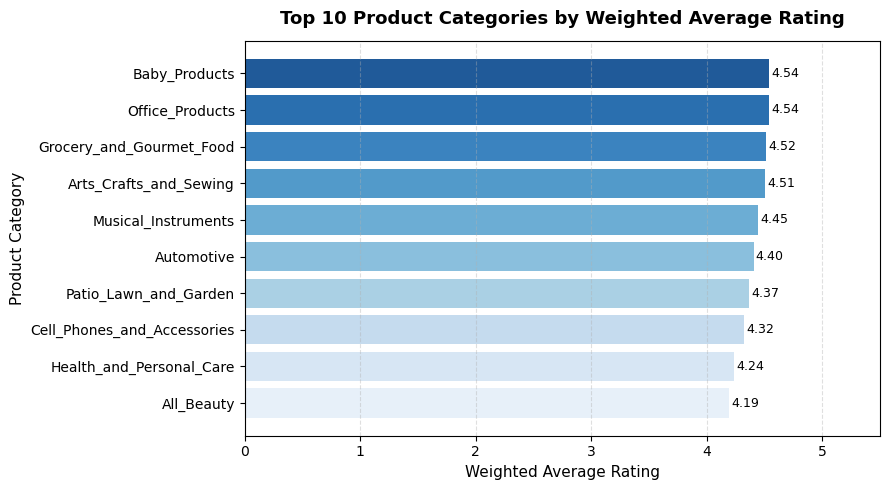

In [73]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute weighted average per category
#
weighted = (
    df_meta.filter(F.col("rating_number") > 0)
    .groupBy("category_name")
    .agg(
        (F.sum(F.col("average_rating") * F.col("rating_number")) / F.sum("rating_number")).alias("weighted_avg"),
        F.count("*").alias("n")
    )
    .orderBy(F.desc("weighted_avg"))
)

# Step 2: Convert to pandas (Top 10)
pdf_weighted = weighted.limit(10).toPandas()

# Step 3: Create gradient color palette based on rating value
colors = sns.color_palette("Blues", n_colors=len(pdf_weighted))
colors = colors[::-1]  # reverse so highest is darkest

# Step 4: Plot
plt.figure(figsize=(9,5))
bars = plt.barh(
    pdf_weighted["category_name"],
    pdf_weighted["weighted_avg"],
    color=colors,
    alpha=0.9
)

# Add numeric labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center', fontsize=9, color='black')

# Labels, title, and styling
plt.xlabel("Weighted Average Rating", fontsize=11)
plt.ylabel("Product Category", fontsize=11)
plt.title("Top 10 Product Categories by Weighted Average Rating", fontsize=13, weight='bold', pad=12)

plt.xlim(0, 5.5)
plt.gca().invert_yaxis()  # highest at top
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**Insights** 

From the chart, we can see that Baby Products, Office Products, and Grocery & Gourmet Food receive the highest ratings on the platform. However, more personal categories such as Beauty, Health & Personal Care, and Cell Phones tend to have lower ratings. This suggests that Amazon performs strongly in general, functional product categories with lower differentiation needs, but is less effective in categories that require personalization and must cater to diverse customer preferences

### 2. Does price influence customer ratings?

We want to dig into the price metric and check if higher price do means better quality (this could dive into deeper analysis by different category but now we look into general conditions

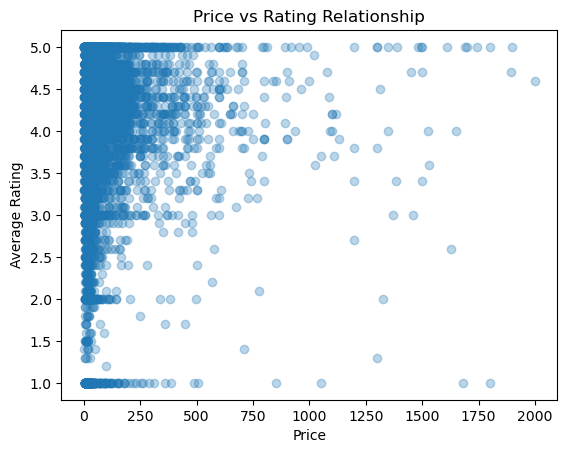

In [74]:
pdf = df_meta.filter(
    (F.col("price") > 0) & (F.col("price") < 2000) & (F.col("average_rating").isNotNull())
).sample(0.01).toPandas()

import matplotlib.pyplot as plt

plt.scatter(pdf["price"], pdf["average_rating"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Average Rating")
plt.title("Price vs Rating Relationship")
plt.show()

**Insights**

Most products, regardless of cost, cluster around 4–5 stars, while lower ratings occur across all price ranges.From the chart, there is no significant trand showing higer price must bring higher rating. But when price reach to $1750, there is less ratings under 2.5.

### 3: Does richer product content (images, videos, longer descriptions) improve ratings?
This chart was created to examine how product content quality, such as images, videos, and description length affects customer ratings and overall satisfaction.

In [75]:
# Step 1: Summarize data by content type and description group
from pyspark.sql import functions as F

# Create descriptive length category
df_meta = df_meta.withColumn("desc_len", F.size(F.col("description")))
df_meta = df_meta.withColumn(
    "desc_group",
    F.when(F.col("desc_len") < 5, "Short")
     .when(F.col("desc_len") < 20, "Medium")
     .otherwise("Long")
)

# Create content type flags
df_meta = df_meta.withColumn("has_image", F.col("product_image").cast("int"))
df_meta = df_meta.withColumn("has_video", F.col("product_video").cast("int"))

# Combine into one content_type label
df_meta = df_meta.withColumn(
    "content_type",
    F.concat_ws(" & ",
        F.when(F.col("has_image") == 1, "With Image").otherwise("No Image"),
        F.when(F.col("has_video") == 1, "With Video").otherwise("No Video")
    )
)

# Aggregate average ratings
df_summary = (
    df_meta.groupBy("content_type", "desc_group")
    .agg(F.avg("average_rating").alias("avg_rating"))
)

# Step 2: Convert to pandas for plotting
pdf_summary = df_summary.toPandas()


/opt/conda/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without as

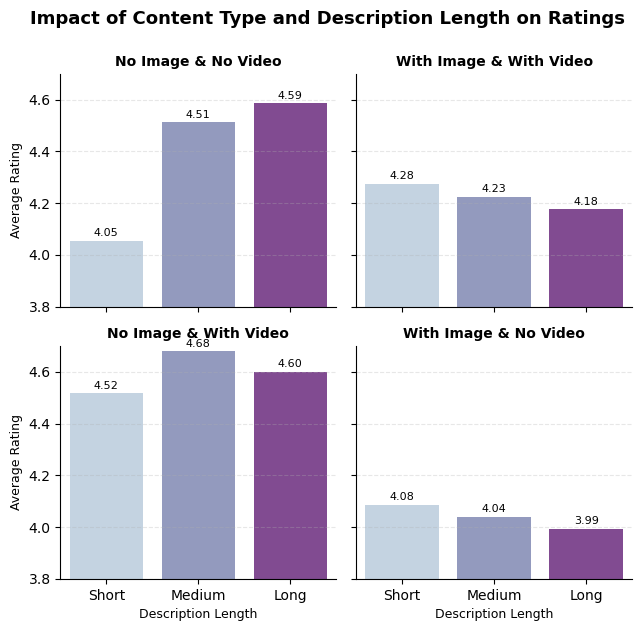

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# FacetGrid with shared y-axis (purple theme)
g = sns.FacetGrid(pdf_summary, col="content_type", col_wrap=2, height=3.2, sharey=True)
g.map_dataframe(
    sns.barplot,
    x="desc_group", y="avg_rating",
    palette=sns.color_palette("BuPu", n_colors=3),
    order=["Short","Medium","Long"]
)

# Unify y-axis scale
g.set(ylim=(3.8, 4.7))

# Add value labels on bars
for ax in g.axes.flatten():
    for c in ax.containers:
        ax.bar_label(c, fmt="%.2f", fontsize=8, padding=2)
    ax.set_xlabel("Description Length", fontsize=9)
    ax.set_ylabel("Average Rating", fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

# Titles and layout
g.set_titles(col_template="{col_name}", size=10, weight='bold')
plt.subplots_adjust(top=0.88)
g.fig.suptitle("Impact of Content Type and Description Length on Ratings", fontsize=13, weight='bold')
plt.show()



**Insights**

From the perspective of product content, items that include videos generally receive higher ratings, while images do not show a clear impact on ratings. For some products, the absence of videos or photos may be due to delisting or content updates, yet their reviews remain; this is something we cannot verify. Overall, we infer that the length of the content description has limited influence on ratings. insight chart 10: Insights -In the product lifecycle, we can observe that the categories All Beauty, Accessories, and Personal Care show noticeably lower ratings in the early stage. This may be related to the wide variation in individual user experiences for these types of products, which means more reviews are needed to help improve their ratings. We recommend strengthening promotional efforts to encourage customer reviews during the early phase. Other categories generally remain stable in each stage.

### 4. Does helpful votes on negative reviews indicate low ratings (unsatisfactory products)?
All Amazon users can vote on whether a review was helpful.
This *helpful (review) vote* serves as an important indicator of how much people are influenced by, or empathize with, reviews that either compliment or criticize a product.

We aim to examine whether these helpful votes are related with the overall product ratings.\
If we find that products receiving many helpful votes on critical (low-rated) reviews tend to have lower average ratings, it would strongly suggest potential issues with product or service quality that such products may require closer monitoring or review.
Conversely, if our hypothesis turns out to be wrong and products with many helpful votes on critical reviews do not show any lower average ratings, it may imply that helpful votes have limited influence on perceived product quality or customer satisfaction.

In [77]:
from pyspark.sql import functions as F
import pandas as pd

# Sum / Calculate helpful votes when Rating=1, Rating=5
df_helpful = (
    df_reviews.groupBy("parent_asin")
      .agg(
          F.avg("rating").alias("avg_rating"),
          F.sum(F.when(F.col("rating") == 1, F.col("helpful_vote")).otherwise(0)).alias("helpful_sum_r1"),
          F.sum(F.when(F.col("rating") == 5, F.col("helpful_vote")).otherwise(0)).alias("helpful_sum_r5")
      )
      .withColumn("helpful_diff", F.col("helpful_sum_r5") - F.col("helpful_sum_r1"))
)

pdf_helpful = df_helpful.toPandas()

# Negative helpful_diff → skew to low ratings, Positive helpful_diff → skew to high ratings
pdf_helpful["trend_group"] = pd.cut(
    pdf_helpful["helpful_diff"],
    bins=[-float("inf"), -1, 0, 1, float("inf")],
    labels=["Mostly 1", "Balanced", "Slightly more on 5", "Mostly 5"]
)


/tmp/ipykernel_4779/3063744857.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_4779/3063744857.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, v in enumerate(pdf_helpful.groupby("trend_group")["avg_rating"].mean()):


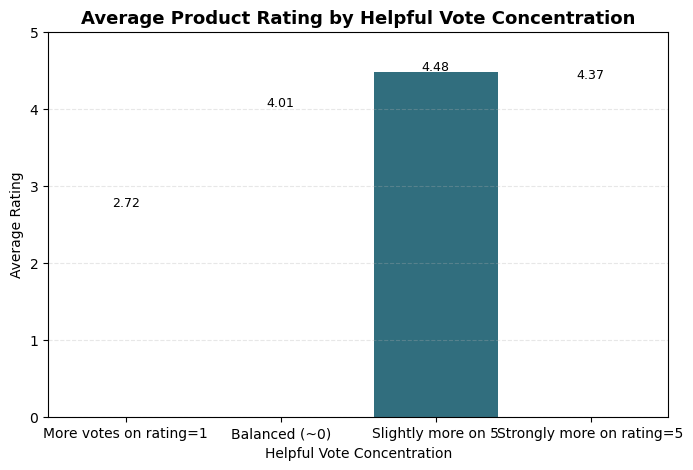

In [78]:
import seaborn as sns
# Show on Bar Graph
plt.figure(figsize=(8,5))
sns.barplot(
    data=pdf_helpful,
    x="trend_group",
    y="avg_rating",
    palette="crest",
    order=["More votes on rating=1", "Balanced (~0)", "Slightly more on 5", "Strongly more on rating=5"]
)

for i, v in enumerate(pdf_helpful.groupby("trend_group")["avg_rating"].mean()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=9)

plt.title("Average Product Rating by Helpful Vote Concentration", fontsize=13, weight='bold')
plt.xlabel("Helpful Vote Concentration")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


**Insight**

According to the graph, we observed a clear decline in the average rating as the number of helpful votes on critical (1-star) reviews increased.
This finding supports our hypothesis: when critical reviews accumulate a large number of helpful votes, it can be considered as a red flag indicating potential issues with the product’s quality or service, warranting further investigation and corrective action.

### 5. Do the most expensive items justify their price when compared to their ratings?
Sometimes we come across listings which seem ultimately vague and absurd. For example, a pair of scissors costing $5600. 
These listings are generally outliers due to improper upload of data/ listing and an analysis of this might be helpful to clean data on a business level.
For now, lets check the top 100 most expensive listings and check their ratings with the help of a bokeh chart.

In [79]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from pyspark.sql import functions as F

output_notebook()

# Select top 100 most expensive items with price, rating, and category
top_100_pdf = (
    df_meta.filter(
        (F.col("price").isNotNull()) & 
        (F.col("average_rating").isNotNull()) &
        (F.col("category_name").isNotNull())
    )
    .withColumn("price_float", F.col("price").cast("double"))
    .filter(F.col("price_float") > 0)
    .select("title", "price_float", "average_rating", "category_name")
    .orderBy(F.desc("price_float"))
    .limit(100)  # top 100
    .toPandas()
)

# Convert to Bokeh ColumnDataSource
source = ColumnDataSource(top_100_pdf)

# Create figure
p = figure(
    title="Top 100 Most Expensive Products vs Ratings",
    x_axis_label='Price ($)',
    y_axis_label='Average Rating',
    width=900,
    height=500,
    tools="pan,wheel_zoom,box_zoom,reset,hover,save"
)

# Add scatter points
p.scatter(
    x='price_float',
    y='average_rating',
    size=10,
    source=source,
    fill_color='navy',
    fill_alpha=0.6,
    line_color=None
)

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Title", "@title"),
    ("Category", "@category_name"),
    ("Price", "@price_float{$0,0.00}"),
    ("Rating", "@average_rating")
]

# Show plot
show(p)
print(top_100_pdf)


Loading BokehJS ...

                                                title  price_float  \
0   1884 S American Silver Morgan Dollar MS-67 Ill...   1099995.00   
1   Sports Memorabilia Cal Ripken Jr. 1981 Rookie ...    890908.99   
2   1895 O American Silver Morgan Dollar MS-66 Ill...    549995.00   
3   1886 O American Silver Morgan Dollar MS-65+ PQ...    539995.00   
4   1885 CC American Silver Morgan Dollar MS-68+ I...    515000.00   
..                                                ...          ...   
95  Comfort Hot Tubs - 6 Person Luxury Outdoor Por...      7500.00   
96  Kohler 20 Kw 83 Amp 120/240 Single Phase Natur...      7400.00   
97  Alfresco ALXE-42-NG 42" Standard Grill Natural...      7299.00   
98  EF ECOFLOW Power Station 3600Wh/3600W DELTA Pr...      7299.00   
99  Palram - Canopia Arizona Wave Double Carport -...      7286.36   

    average_rating           category_name  
0              3.5  Arts_Crafts_and_Sewing  
1              4.7  Arts_Crafts_and_Sewing  
2              2.3  Arts

**Insights**

The chart reveals that several listings cluster around the lower end of the rating spectrum, indicating that multiple products or services are underperforming in terms of customer satisfaction. Ideally, a healthy marketplace or product portfolio would display a scatterplot concentrated toward the upper-right quadrant—signifying higher ratings and potentially stronger value propositions relative to their price points.
#However, in this case, the dense concentration of data points in the bottom-left area suggests a mismatch between price and perceived quality. This could mean that customers feel the offerings are overpriced for the value delivered, or that there are fundamental issues with quality, service experience, or product relevance.

### 6. Based on previous finding, we decide to dig in deeper to a pricing question that sellers might have"  Is my product overpriced or underpriced compared to similar items in the same category?"


In [55]:
from pyspark.sql import functions as F

META_COMBINED_COMPACT = "gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact"

df_meta = (spark.read
           .option("recursiveFileLookup", "true")
           .parquet(META_COMBINED_COMPACT))

+------------+------+
|price_bucket| count|
+------------+------+
|   $100-$200| 57249|
|     $20-$50|323294|
|   $200-$500| 30336|
|    $50-$100|101044|
|        <$20|760524|
|       >$500|  8712|
+------------+------+



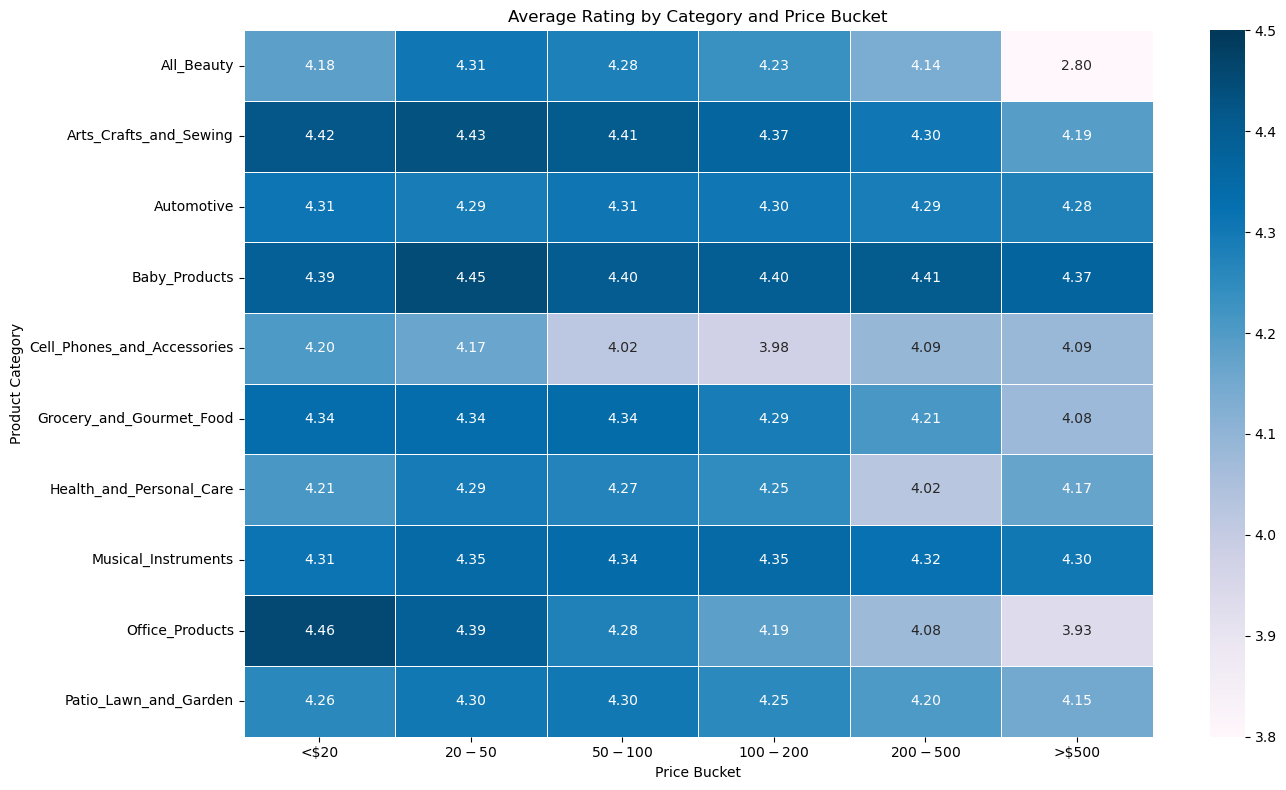

In [56]:
from pyspark.sql import functions as F

META_COMBINED_COMPACT = "gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact"

df_meta = (spark.read
           .option("recursiveFileLookup", "true")
           .parquet(META_COMBINED_COMPACT))

# Filter products with valid price & rating
df_priced = (
    df_meta
    .filter((F.col("price") > 0) & F.col("average_rating").isNotNull())
    .filter(F.col("rating_number") >= 10)
)

#Create clean bucket ranges
df_priced = df_priced.withColumn(
    "price_bucket",
    F.when(F.col("price") < 20, "<$20")
     .when((F.col("price") >= 20) & (F.col("price") < 50), "$20-$50")
     .when((F.col("price") >= 50) & (F.col("price") < 100), "$50-$100")
     .when((F.col("price") >= 100) & (F.col("price") < 200), "$100-$200")
     .when((F.col("price") >= 200) & (F.col("price") < 500), "$200-$500")
     .otherwise(">$500")
)

df_priced.groupBy("price_bucket").count().orderBy("price_bucket").show()


REVIEWS_SILVER = "gs://qst843-project/amazon_reviews_2023/silver/reviews_combined_compact"

df_reviews = (
    spark.read
        .option("recursiveFileLookup", "true")
        .parquet(REVIEWS_SILVER)
)

df_bucket_stats = (
    df_priced
    .groupBy("category_name", "price_bucket")
    .agg(
        F.count("*").alias("n_products"),
        F.avg("average_rating").alias("bucket_avg_rating")
    )
)

bucket_pdf = df_bucket_stats.toPandas()

# clean lables
bucket_pdf["category_name"] = bucket_pdf["category_name"].str.strip()
bucket_pdf["price_bucket"] = (
    bucket_pdf["price_bucket"]
    .str.strip()
    .str.replace("–", "-", regex=False)
    .str.replace("—", "-", regex=False)
)

# Build heatmap and plot it 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_df = bucket_pdf.pivot_table(
    index="category_name",
    columns="price_bucket",
    values="bucket_avg_rating",
    aggfunc="mean"
)

bucket_order = ["<$20", "$20-$50", "$50-$100", "$100-$200", "$200-$500", ">$500"]
existing = [b for b in bucket_order if b in heatmap_df.columns]
heatmap_df = heatmap_df[existing]

# Change different color to make the chart more clear. 
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_df,
    annot=True, fmt=".2f",
    cmap="PuBu",
    linewidths=0.5,
    vmin=3.8,
    vmax=4.5
)


plt.title("Average Rating by Category and Price Bucket")
plt.xlabel("Price Bucket")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


From the graph, we can see differnt category shows different rating range. next step, we designed a formula to check the distribution of price fairness.

PFI= product_rating - bucket_avg_rating

This will help us to check if the price has overprice/uderprice issue on the market

<function matplotlib.pyplot.show(close=None, block=None)>

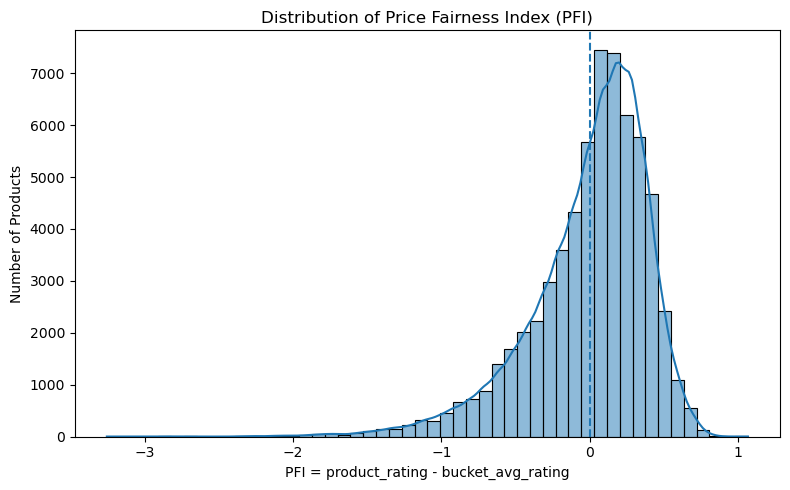

In [57]:
from pyspark.sql import functions as F

META_COMBINED_COMPACT = "gs://qst843-project/amazon_reviews_2023/silver/meta_combined_compact"

df_meta = (spark.read
           .option("recursiveFileLookup", "true")
           .parquet(META_COMBINED_COMPACT))

df_priced = (df_meta
    .filter((F.col("price") > 0) & F.col("average_rating").isNotNull())
    .filter(F.col("rating_number") >= 10)
    .withColumn(
        "price_bucket",
        F.when(F.col("price") < 20, "<$20")
         .when((F.col("price") >= 20) & (F.col("price") < 50), "$20-$50")
         .when((F.col("price") >= 50) & (F.col("price") < 100), "$50-$100")
         .when((F.col("price") >= 100) & (F.col("price") < 200), "$100-$200")
         .when((F.col("price") >= 200) & (F.col("price") < 500), "$200-$500")
         .otherwise(">$500")
    )
)

df_bucket_stats = (
    df_priced
    .groupBy("category_name", "price_bucket")
    .agg(
        F.count("*").alias("n_products"),
        F.avg("average_rating").alias("bucket_avg_rating")
    )
)
df_pfi = (
    df_priced.alias("p")
    .join(
        df_bucket_stats.select(
            "category_name", "price_bucket", "bucket_avg_rating"
        ).alias("b"),
        on=["category_name", "price_bucket"],
        how="left"
    )
    .withColumn(
        "price_fairness_index",
        F.col("p.average_rating") - F.col("b.bucket_avg_rating")
    )
)

# adjust thresholds if you want stricter/looser
OVERPRICED_THR = -0.3
VALUE_THR = 0.3

df_overpriced = (
    df_pfi
    .filter(F.col("price_fairness_index") <= OVERPRICED_THR)
    .orderBy("price_fairness_index")  # most negative first
    .select("parent_asin", "title", "category_name", "price",
            "average_rating", "bucket_avg_rating", "price_fairness_index",
            "rating_number")
)

df_value = (
    df_pfi
    .filter(F.col("price_fairness_index") >= VALUE_THR)
    .orderBy(F.col("price_fairness_index").desc())  # best value first
    .select("parent_asin", "title", "category_name", "price",
            "average_rating", "bucket_avg_rating", "price_fairness_index",
            "rating_number")
)


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample for plotting if df_pfi is huge
pfi_pdf = df_pfi.select("price_fairness_index").sample(fraction=0.05, seed=42).toPandas()

plt.figure(figsize=(8, 5))
sns.histplot(pfi_pdf["price_fairness_index"], bins=50, kde=True)
plt.axvline(0, linestyle="--")
plt.title("Distribution of Price Fairness Index (PFI)")
plt.xlabel("PFI = product_rating - bucket_avg_rating")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show

**Insight**

From the chart, we can see that most products on Amazon are fairly priced. However, there are some long-tail phenomena in the graph. Our next step is to identify which categories are contributing to this issue.

### 7. Which categories contribute to products not being fairly priced?

/tmp/ipykernel_4779/1947794767.py:64: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


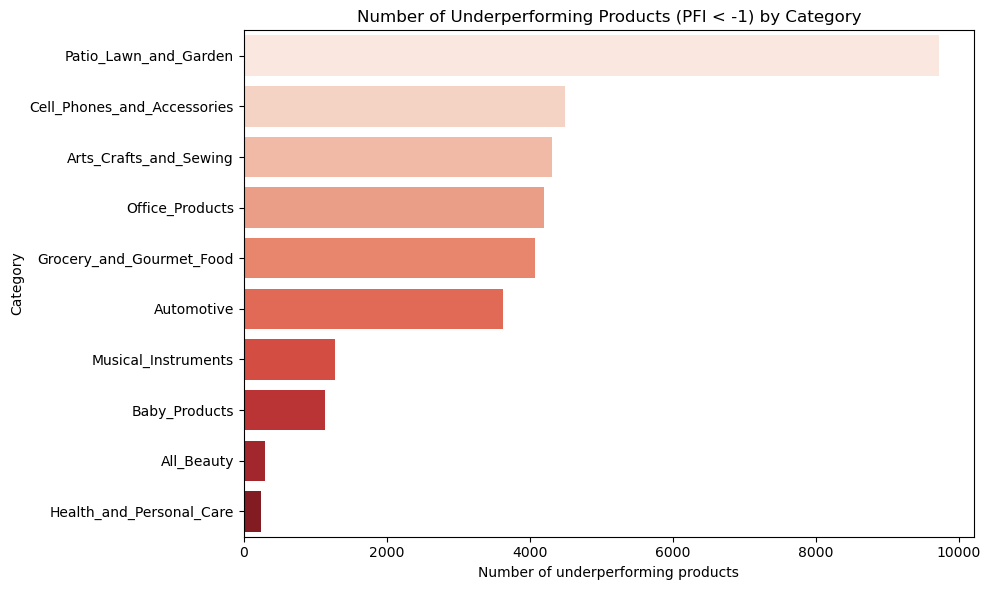

In [58]:
# Create PFI groups (under / normal / over)
from pyspark.sql import functions as F

df_extreme = (
    df_pfi
    .withColumn(
        "pfi_group",
        F.when(F.col("price_fairness_index") <= -1, "underperforming (< -1)")
         .when(F.col("price_fairness_index") >= 1, "overperforming (> 1)")
         .otherwise("normal")
    )
)

df_extreme_category = (
    df_extreme
    .groupBy("category_name", "pfi_group")
    .count()
    .orderBy("category_name", "pfi_group")
)

# Pivot to one row per category 
df_pivot = (
    df_extreme_category
    .groupBy("category_name")
    .pivot(
        "pfi_group",
        ["underperforming (< -1)", "normal", "overperforming (> 1)"]
    )
    .agg(F.first("count"))
    .orderBy("category_name")
)

# Add total + % underperforming (ignore overperforming)
df_percent = (
    df_pivot
    .withColumn(
        "over_fixed",
        F.coalesce(F.col("overperforming (> 1)"), F.lit(0))
    )
    .withColumn(
        "total",
        F.col("underperforming (< -1)") +
        F.col("normal") +
        F.col("over_fixed")
    )
    .withColumn(
        "pct_under",
        F.col("underperforming (< -1)") / F.col("total")
    )
)

counts_pdf = (
    df_pivot
    .select(
        "category_name",
        F.col("underperforming (< -1)").alias("under_count")
    )
    .toPandas()
)

counts_pdf = counts_pdf.sort_values("under_count", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=counts_pdf,
    x="under_count",
    y="category_name",
    palette="Reds"
)
plt.title("Number of Underperforming Products (PFI < -1) by Category")
plt.xlabel("Number of underperforming products")
plt.ylabel("Category")
plt.tight_layout()
plt.show()



**Insights**

Across all subplots, products that include videos or images consistently receive higher ratings than those without.Interestingly, products with shorter or medium-length descriptions also tend to perform slightly better than those with long ones — possibly because concise information improves readability and trust.This supports the hypothesis that visual and clear content presentation positively affects perceived product quality.

### PRODUCT LIFE CYCLE CURVE ANALYSIS
### 8. How do product ratings evolve from launch to maturity?
Why does this matters for Amazon sellers
Early reviews heavily influence ranking & conversion.
Mid-life “rating crashes” indicate quality degradation, supplier changes, or increased returns.
Helps detect review manipulation (suspiciously high first 10 reviews).
Identifies optimal intervention timing (e.g., price cuts, listing improvement).

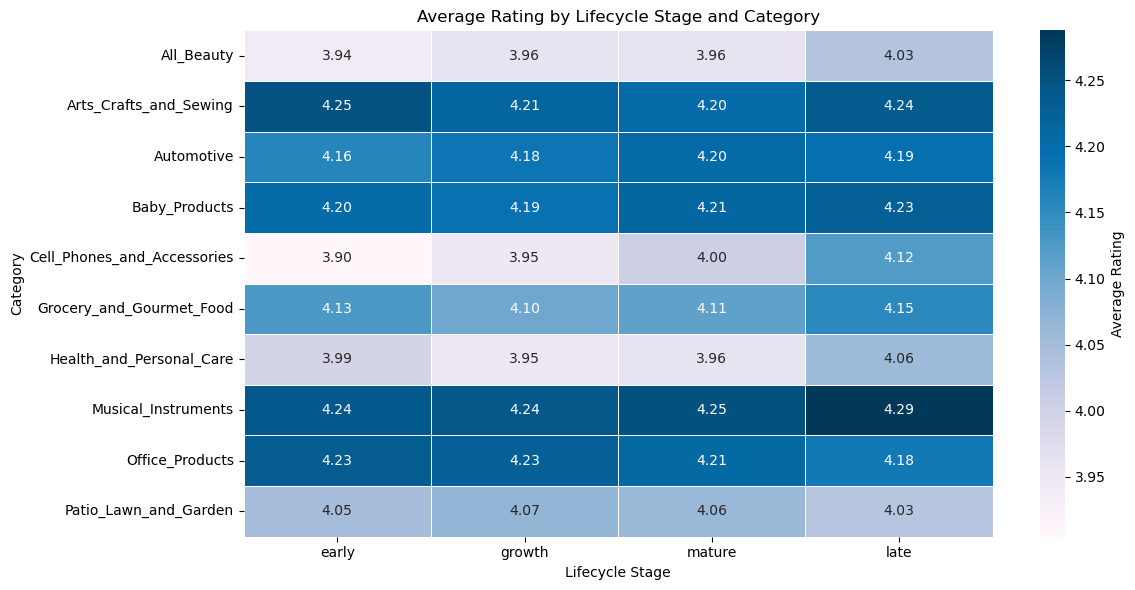

In [59]:
from pyspark.sql import functions as F

REVIEWS_SILVER = "gs://qst843-project/amazon_reviews_2023/silver/reviews_combined_compact"

df_reviews = (
    spark.read
        .option("recursiveFileLookup", "true")
        .parquet(REVIEWS_SILVER)
)

from pyspark.sql import Window
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# STEP 1: Compute per-product review counts per category
# ------------------------------------------------------------
df_review_counts = (
    df_reviews
    .groupBy("category_name", "parent_asin")
    .agg(F.count("*").alias("n_reviews"))
)

# ------------------------------------------------------------
# STEP 2: Category-level review volume statistics
#   We compute:
#   - avg_reviews: average number of reviews per product
#   - median_reviews: 50th percentile
#   - p90_reviews: 90th percentile (typical "upper" volume)
#   - p99_reviews: 99th percentile (top products)
# ------------------------------------------------------------
df_category_stats = (
    df_review_counts
    .groupBy("category_name")
    .agg(
        F.avg("n_reviews").alias("avg_reviews"),
        F.expr("percentile(n_reviews, 0.5)").alias("median_reviews"),
        F.expr("percentile(n_reviews, 0.9)").alias("p90_reviews"),
        F.expr("percentile(n_reviews, 0.99)").alias("p99_reviews")
    )
)


# ------------------------------------------------------------
# STEP 3: Define lifecycle thresholds per category
#   Design logic:
#     - early_max: first 10 reviews  → launch / bias zone
#     - growth_max: up to p90_reviews → main growth & stabilization
#     - maturity_max: up to p99_reviews → long-term mature behavior
#     - > p99_reviews → late stage (high-traction products only)
# ------------------------------------------------------------
df_thresholds = (
    df_category_stats
    .withColumn("early_max", F.lit(10))
    .withColumn("growth_max", F.col("p90_reviews"))
    .withColumn("maturity_max", F.col("p99_reviews"))
)

# ------------------------------------------------------------
# STEP 4: Build lifecycle base table with review_order per product
#   We:
#     - order reviews by timestamp within each parent_asin
#     - assign review_order = 1,2,3,... per product
#   IMPORTANT: we keep category_name so we can join thresholds.
# ------------------------------------------------------------
w = Window.partitionBy("parent_asin").orderBy("timestamp")

df_lifecycle = (
    df_reviews
    .select("parent_asin", "category_name", "rating", "timestamp")
    .withColumn("review_order", F.row_number().over(w))
)

# ------------------------------------------------------------
# STEP 5: Assign lifecycle_stage using category-specific thresholds
#   Stages:
#     - early:   review_order <= early_max
#     - growth:  early_max < review_order <= growth_max
#     - mature:  growth_max < review_order <= maturity_max
#     - late:    review_order  > maturity_max
# ------------------------------------------------------------
df_with_stage = (
    df_lifecycle
    .join(df_thresholds.select("category_name", "early_max", "growth_max", "maturity_max"),
          on="category_name",
          how="left")
    .withColumn(
        "lifecycle_stage",
        F.when(F.col("review_order") <= F.col("early_max"), "early")
         .when(F.col("review_order") <= F.col("growth_max"), "growth")
         .when(F.col("review_order") <= F.col("maturity_max"), "mature")
         .otherwise("late")
    )
)


# ------------------------------------------------------------
# STEP 6: Aggregate average rating and counts per (category, lifecycle_stage)
#   This answers:
#     - How does the average rating evolve from early → growth → mature → late?
#     - Are some categories more volatile than others?
# ------------------------------------------------------------
df_stage_stats = (
    df_with_stage
    .groupBy("category_name", "lifecycle_stage")
    .agg(
        F.avg("rating").alias("avg_rating"),
        F.count("*").alias("n_reviews")
    )
    .orderBy("category_name", "lifecycle_stage")
)

import pandas as pd

# ------------------------------------------------------------
# STEP 7: Convert to pandas and build a heatmap
#   Rows:    categories
#   Columns: lifecycle stages (early, growth, mature, late)
#   Cells:   average rating
#   This visually shows:
#     - Do ratings start high then drop?
#     - When do they stabilize?
#     - Which categories see late-stage decline?
# ------------------------------------------------------------
stage_pdf = df_stage_stats.toPandas()

# Ensure consistent stage ordering in the heatmap columns
stage_order = ["early", "growth", "mature", "late"]
stage_pdf["lifecycle_stage"] = pd.Categorical(
    stage_pdf["lifecycle_stage"], categories=stage_order, ordered=True
)

heatmap_df = stage_pdf.pivot(
    index="category_name",
    columns="lifecycle_stage",
    values="avg_rating"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_df,
    annot=True, fmt=".2f",
    cmap="PuBu",
    linewidths=0.5,
    cbar_kws={"label": "Average Rating"}
)

plt.title("Average Rating by Lifecycle Stage and Category")
plt.xlabel("Lifecycle Stage")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


**Insight**

Across all lifecycle stages, average ratings remain relatively stable, suggesting that product quality expectations stay consistent from early launch to late-stage maturity. However, some categories—such as Arts, Crafts & Sewing, Musical Instruments, and Automotive—consistently outperform others, indicating stronger product–market fit and better customer satisfaction throughout their lifecycle.

Categories like Cell Phones & Accessories and Health & Personal Care have slightly lower ratings across all stages, which may reflect higher customer expectations, rapid innovation cycles, and increased competition. These lower, more volatile ratings signal where sellers may need to focus on improving product presentation, quality control, or customer support.

Overall, the heatmap highlights which categories sustain strong customer perceptions over time and which ones require more targeted improvement. This helps sellers prioritize where to refine listings, enhance visual content, improve descriptions, or optimize product attributes at each stage of the lifecycle.

### 9. What is the lifecycle for each category listed on Amazon?

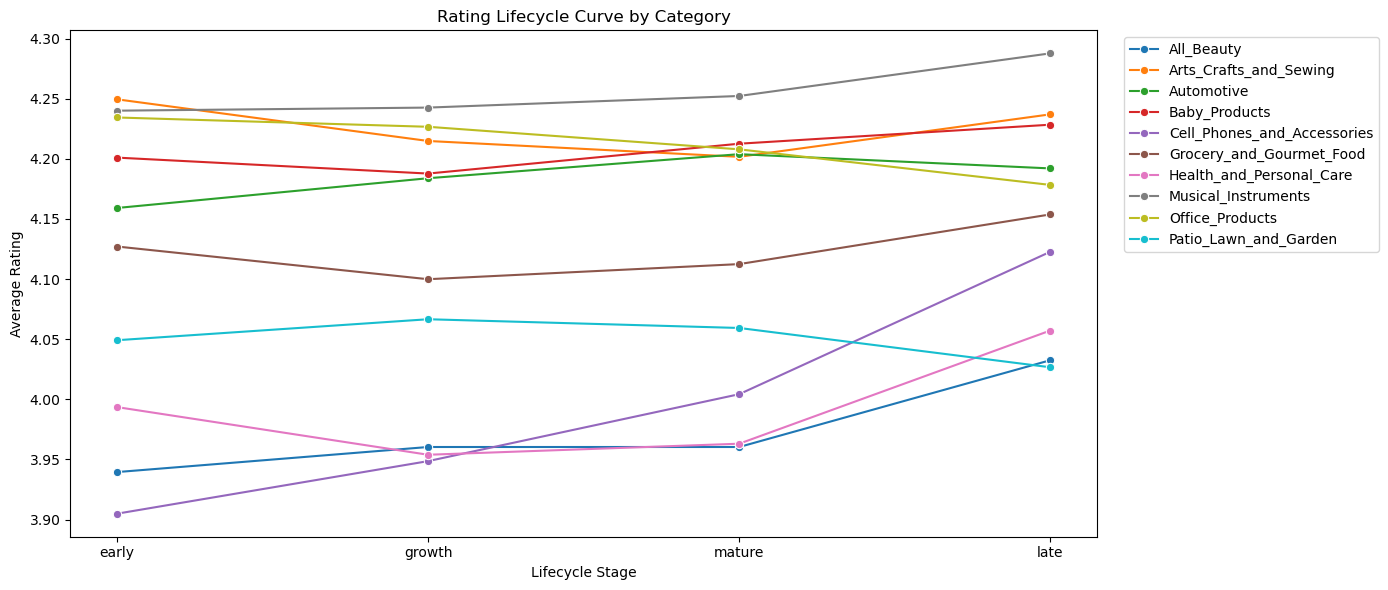

In [60]:
# Category Lifecycle Line Chart
import matplotlib.pyplot as plt
import seaborn as sns

stage_pdf_sorted = stage_pdf.sort_values(["category_name", "lifecycle_stage"])
plt.figure(figsize=(14, 6))

sns.lineplot(
    data=stage_pdf_sorted,
    x="lifecycle_stage",
    y="avg_rating",
    hue="category_name",
    marker="o"
)

plt.title("Rating Lifecycle Curve by Category")
plt.xlabel("Lifecycle Stage")
plt.ylabel("Average Rating")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

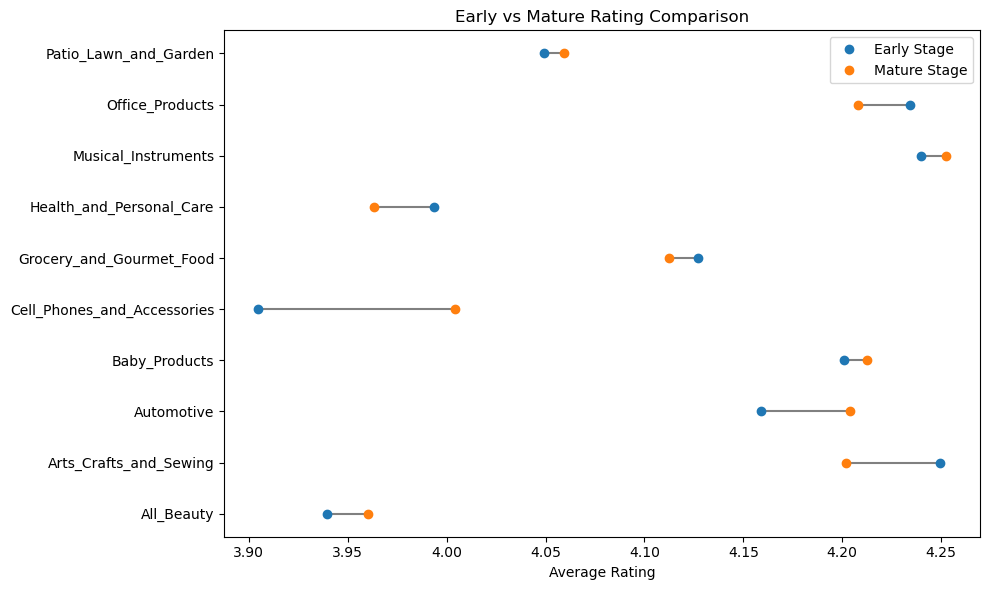

In [61]:
import seaborn as sns
import pandas as pd

pivot_butterfly = stage_pdf.pivot(
    index="category_name",
    columns="lifecycle_stage",
    values="avg_rating"
)

butterfly_df = pivot_butterfly[["early", "mature"]].dropna()

plt.figure(figsize=(10, 6))
plt.hlines(butterfly_df.index, butterfly_df["early"], butterfly_df["mature"], color="gray")
plt.plot(butterfly_df["early"], butterfly_df.index, "o", label="Early Stage")
plt.plot(butterfly_df["mature"], butterfly_df.index, "o", label="Mature Stage")

plt.title("Early vs Mature Rating Comparison")
plt.xlabel("Average Rating")
plt.legend()
plt.tight_layout()
plt.show()

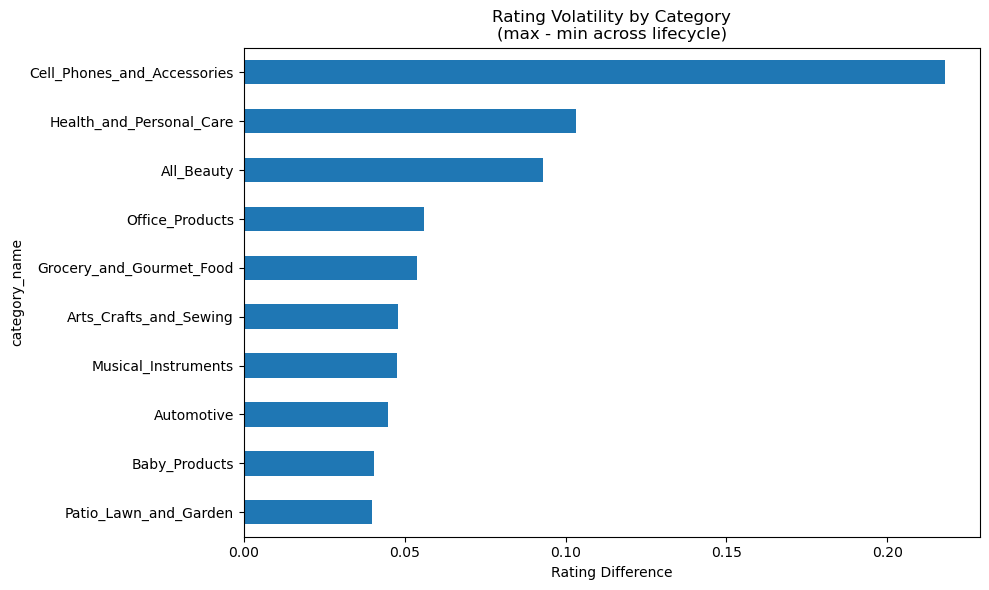

In [62]:
vol_df = stage_pdf.pivot(index="category_name", columns="lifecycle_stage", values="avg_rating")
vol_df["volatility"] = vol_df.max(axis=1) - vol_df.min(axis=1)

vol_df["volatility"].sort_values().plot(kind="barh", figsize=(10,6))
plt.title("Rating Volatility by Category\n(max - min across lifecycle)")
plt.xlabel("Rating Difference")
plt.tight_layout()
plt.show()

**Insights**

Across all categories, product ratings remain relatively stable throughout the lifecycle, indicating that customer perception of quality does not dramatically decline as products age. However, certain categories such as Musical Instruments, Arts, Crafts & Sewing, and Baby Products maintain consistently high ratings from early through late stages, suggesting strong brand trust and well-established product expectations.

On the other hand, categories like Health & Personal Care and Cell Phones & Accessories show more noticeable fluctuations, with lower ratings in early stages and improvement toward the late stage. This may reflect stricter customer expectations or the presence of more variability in product quality early on, stabilizing only after customer feedback guides refinements.

Interestingly, some categories (e.g., Grocery & Gourmet Food and Automotive) experience slight dips in the middle stages before recovering, which could indicate competition, saturation, or shifts in customer preferences during the product’s lifecycle.

Overall, the lifecycle curves help identify which categories deliver consistent customer satisfaction over time and where sellers may need to focus on tightening quality, refining listings, or improving product positioning at different lifecycle stages.

### TEXT LENGTH vs. RATING EXTREMES
### 10. Do long reviews indicate anger (1-star) or enthusiasm (5-star)?

Why this matters?

• Long negative reviews → detailed complaints → product defects \
• Long positive reviews → strong brand loyalty \
• Great for NLP feature engineering (review_length improves predictive power) \
• Helps prioritize which reviews sellers should read manually 

/tmp/ipykernel_4779/4074612147.py:21: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_len_pdf, x="rating", y="avg_length", palette="Blues")


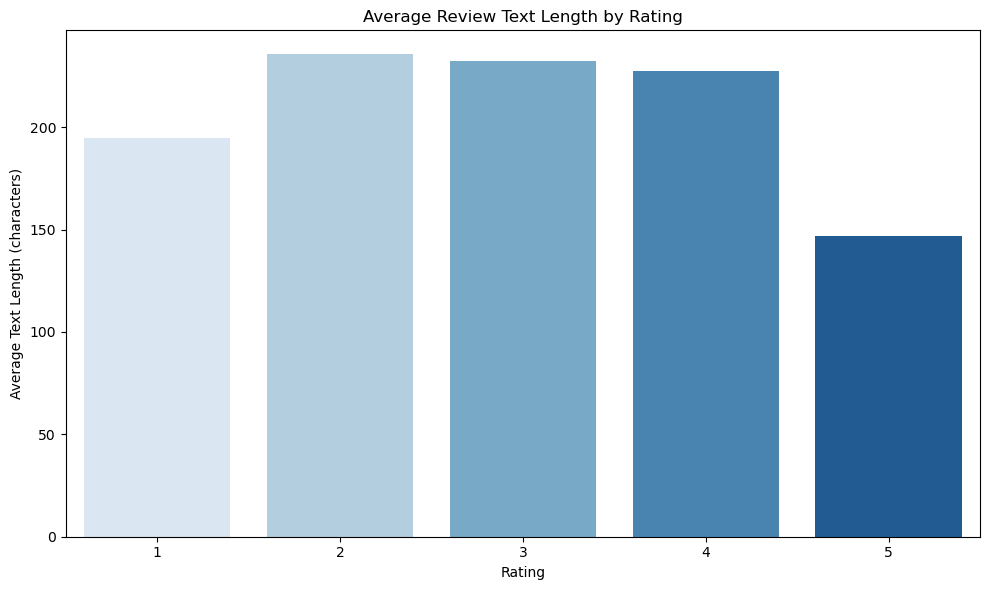

In [ ]:
# Compute review text length and average text length per rating score
df_text = df_reviews.select(
    "category_name",
    "rating",
    F.length("text").alias("text_length")
)

df_len_rating = (
    df_text
    .groupBy("rating")
    .agg(
        F.avg("text_length").alias("avg_length"),
        F.expr("percentile(text_length, 0.5)").alias("median_length")
    )
    .orderBy("rating")
)

df_len_pdf = df_len_rating.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_len_pdf, x="rating", y="avg_length", palette="Blues")
plt.title("Average Review Text Length by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Text Length (characters)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_4779/2411887119.py:37: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


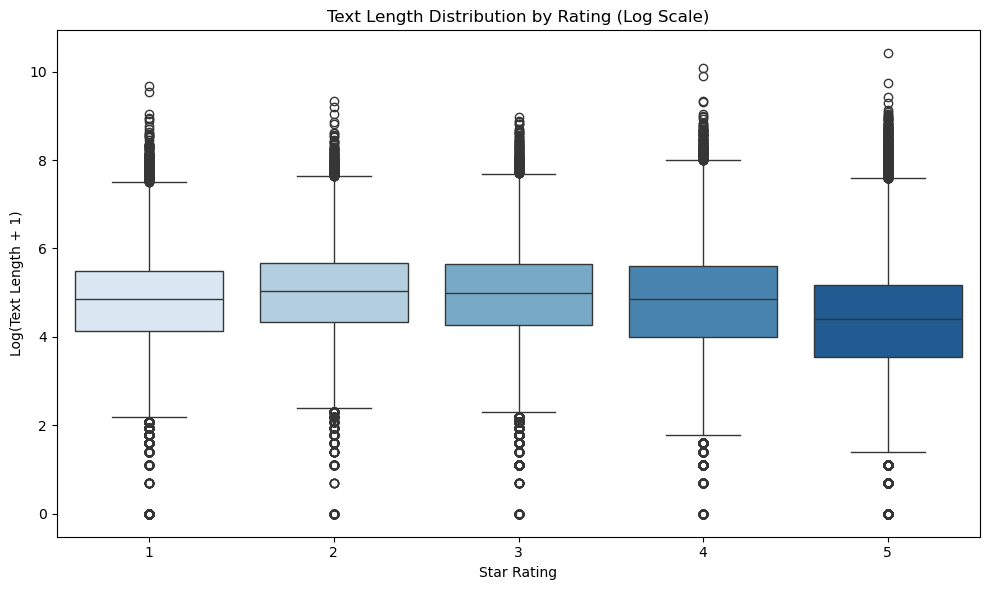

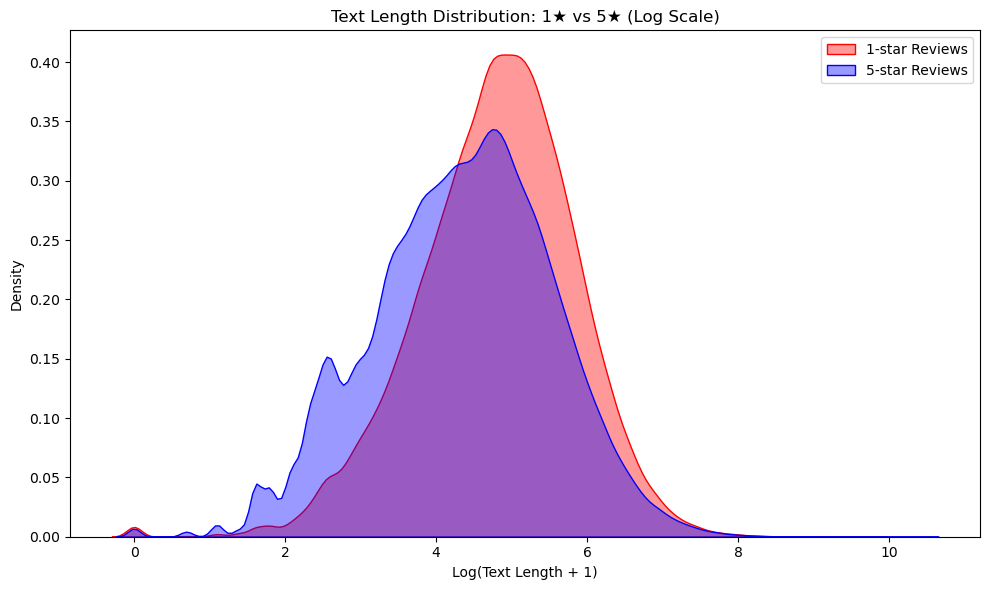

In [ ]:
# ============================================================
# TEXT LENGTH vs RATING EXTREMES — One Cell Visualization
# ============================================================

from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# STEP 1: Create text_length column (Spark)
# ------------------------------------------------------------
df_text = df_reviews.select(
    "rating",
    F.length("text").alias("text_length")
).filter(F.col("text_length").isNotNull())

# ------------------------------------------------------------
# STEP 2: Sample data for visualization (1% sample)
#   Avoid pulling 100M rows into Pandas
# ------------------------------------------------------------
df_text_sample = (
    df_text.sample(fraction=0.01, seed=42)
            .toPandas()
)

# ------------------------------------------------------------
# STEP 3: Log transform for long-tail text length distribution
# ------------------------------------------------------------
df_text_sample["log_text_length"] = np.log1p(df_text_sample["text_length"])

# ------------------------------------------------------------
# STEP 4: BOXPLOT — Text Length Distribution by Rating
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_text_sample,
    x="rating",
    y="log_text_length",
    palette="Blues"
)

plt.title("Text Length Distribution by Rating (Log Scale)")
plt.xlabel("Star Rating")
plt.ylabel("Log(Text Length + 1)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# STEP 5: KDE Plot — Compare 1★ vs 5★ (Extremes Only)
# ------------------------------------------------------------
extreme_pdf = df_text_sample[df_text_sample["rating"].isin([1.0, 5.0])]

plt.figure(figsize=(10, 6))

sns.kdeplot(
    data=extreme_pdf[extreme_pdf["rating"] == 1.0],
    x="log_text_length",
    label="1-star Reviews",
    fill=True,
    alpha=0.4,
    color="red"
)

sns.kdeplot(
    data=extreme_pdf[extreme_pdf["rating"] == 5.0],
    x="log_text_length",
    label="5-star Reviews",
    fill=True,
    alpha=0.4,
    color="blue"
)

plt.title("Text Length Distribution: 1★ vs 5★ (Log Scale)")
plt.xlabel("Log(Text Length + 1)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


**Insight**

We also examined the text length to determine whether it is a factor influencing ratings. From the line chart, we observe that aside from Rating 5, other rating scores show similar length distributions. The boxplot further confirms that ratings from 1 to 4 follow the same pattern, while Rating 5 tends to have noticeably shorter review paragraphs. The text-length distribution also suggests that users typically write more when giving a Rating 1, likely because they want to express complaints in greater detail. But in general, text is not the main reason affect rating

## Prediction Models with ML

### Joined Date Frame

In [65]:
# Join Review & Meta Data into a Single df
df = df_reviews.join(
    df_meta,
    on="parent_asin",
    how="left"
)
# Check Joined Data
df.printSchema()
df.show()

root
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- rating: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_image: boolean (nullable = true)
 |-- category_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: double (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- brand: string (nullable = true)
 |-- store: string (nullable = true)
 |-- product_image: bool

+-----------+--------------------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------+-------------+-----+--------------------+-------------+-------------+--------------------+
|parent_asin|             user_id|          timestamp|rating|               title|                text|helpful_vote|verified_purchase|review_image|       category_name|               title|       main_category|          categories| price|            features|         description|average_rating|rating_number|brand|               store|product_image|product_video|       category_name|
+-----------+--------------------+-------------------+------+--------------------+--------------------+------------+-----------------+------------+--------------------+--------------------+--------------------+------------------

### Model 1 - Average rating prediction 
- Using **main_category, description_words, price, product_image, product_video**
- For sellers, it would be best to predict higher average customer ratings, optimizing their variables in their product pages. We expect to find a model that can predict avg. ratings with **main_category, description_words, price, product_image, product_video**.

In [29]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# 1. Data Filtering
df_meta_ml = df_meta.select(
    "main_category",
    "price",
    "average_rating",
    "product_name",
    "product_image",
    "product_video",
    "description"
)

initial_count = df_meta_ml.count()
print(f"1. Initial data count: {initial_count}")

df_meta_ml = df_meta_ml.filter(F.col("price").isNotNull())

df_meta_ml = df_meta_ml.na.drop(
    how='all', 
    subset=["main_category", "product_image", "product_video"]
)

remaining_count = df_meta_ml.count()
print(f"2. Remaining data count after dropping NAs: {remaining_count}")
print(f"   (Dropped rows: {initial_count - remaining_count})")

if remaining_count < 100:
    print("WARNING: Too few data points remaining. Model training might be difficult.")

# 2. Feature Engineering
df_meta_ml = df_meta_ml.withColumn(
    "description_words",
    F.when(F.col("description").isNull(), F.lit(0))
     .otherwise(F.size(F.split(F.concat_ws(" ", F.col("description")), r"\s+")))
)

df_meta_ml = df_meta_ml.withColumn("product_name_clean", F.coalesce(F.col("product_name"), F.lit("")))

df_meta_ml = df_meta_ml.withColumn(
    "name_word_count",
    F.size(F.split(F.trim(F.col("product_name_clean")), r"\s+"))
)
df_meta_ml = df_meta_ml.withColumn(
    "name_word_count",
    F.when(F.col("product_name_clean") == "", 0).otherwise(F.col("name_word_count"))
)

df_meta_ml = df_meta_ml.withColumn(
    "upper_char_count",
    F.length(F.regexp_replace(F.col("product_name_clean"), "[^A-Z]", ""))
)
df_meta_ml = df_meta_ml.withColumn(
    "caps_ratio",
    F.when(F.length(F.col("product_name_clean")) > 0, 
           F.col("upper_char_count") / F.length(F.col("product_name_clean")))
     .otherwise(0.0)
)

df_meta_ml = df_meta_ml.withColumn(
    "has_special_chars",
    F.when(F.col("product_name_clean").rlike(r"[^a-zA-Z0-9\s]"), 1).otherwise(0)
)

# 3. Cleaning & Type Casting
df_meta_ml = df_meta_ml.drop("description", "product_name", "product_name_clean", "upper_char_count")

df_meta_ml_clean = df_meta_ml.fillna({
    "main_category": "Unknown",
    "product_image": False,
    "product_video": False,
    "caps_ratio": 0.0
})

df_meta_ml_clean = (
    df_meta_ml_clean
    .withColumn("product_image_int", F.col("product_image").cast("int"))
    .withColumn("product_video_int", F.col("product_video").cast("int"))
)

# 4. ML Pipeline
indexer = StringIndexer(inputCol="main_category", outputCol="main_category_idx", handleInvalid="keep")
encoder = OneHotEncoder(inputCol="main_category_idx", outputCol="main_category_vec")

assembler = VectorAssembler(
    inputCols=[
        "price",              
        "name_word_count",    
        "caps_ratio",         
        "has_special_chars",  
        "product_image_int",  
        "product_video_int",  
        "description_words",  
        "main_category_vec"   
    ],
    outputCol="features"
)

rf = RandomForestRegressor(
    labelCol="average_rating",
    featuresCol="features",
    numTrees=150,
    maxDepth=10,
    seed=42
)

pipeline = Pipeline(stages=[indexer, encoder, assembler, rf])

# 5. Model Train & Evaluation
train, test = df_meta_ml_clean.randomSplit([0.7, 0.3], seed=42)

model = pipeline.fit(train)
pred = model.transform(test)

evaluator_rmse = RegressionEvaluator(labelCol="average_rating", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="average_rating", predictionCol="prediction", metricName="r2")

print(f"RMSE: {evaluator_rmse.evaluate(pred)}")
print(f"R2: {evaluator_r2.evaluate(pred)}")

# 6. Feature Importance
rf_model = model.stages[-1]
importances = rf_model.featureImportances.toArray()

numeric_features = [
    "price", 
    "name_word_count", 
    "caps_ratio", 
    "has_special_chars", 
    "product_image_int", 
    "product_video_int", 
    "description_words"
]

print("\n[Feature Importance]")
for i, name in enumerate(numeric_features):
    print(f"{name}: {importances[i]:.4f}")

1. Initial data count: 5244716


2. Remaining data count after dropping NAs: 1926217
   (Dropped rows: 3318499)


25/12/09 04:50:50 WARN DAGScheduler: Broadcasting large task binary with size 1635.0 KiB
25/12/09 04:51:02 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/12/09 04:51:16 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
25/12/09 04:51:31 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB
25/12/09 04:51:33 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
25/12/09 04:51:50 WARN DAGScheduler: Broadcasting large task binary with size 2019.3 KiB
25/12/09 04:51:52 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
25/12/09 04:52:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


RMSE: 0.6747654865555409


R2: 0.03066360193225315

[Feature Importance]
price: 0.0845
name_word_count: 0.0673
caps_ratio: 0.0342
has_special_chars: 0.0100
product_image_int: 0.0000
product_video_int: 0.1661
description_words: 0.0991


In [30]:
import pandas as pd

# 1. Extract objects from the model for main_category
indexer_model = model.stages[0]
rf_model = model.stages[-1]

# 2. Get importance vector
all_importances = rf_model.featureImportances.toArray()

# 3. Process Numeric Features
numeric_features = [
    "price", 
    "name_word_count", 
    "caps_ratio", 
    "has_special_chars", 
    "product_image_int", 
    "product_video_int", 
    "description_words"
]
num_count = len(numeric_features)

features_list = []
for i in range(num_count):
    features_list.append({
        "Feature": numeric_features[i], 
        "Type": "Numeric", 
        "Importance": all_importances[i]
    })

# 4. Process main_category
cat_labels = indexer_model.labels 
cat_importances_vec = all_importances[num_count:]

for i, score in enumerate(cat_importances_vec):
    if i < len(cat_labels):
        label_name = f"Category: {cat_labels[i]}"
        features_list.append({
            "Feature": label_name, 
            "Type": "Category", 
            "Importance": score
        })

# 5. Create df and sort
df_importance = pd.DataFrame(features_list)
df_importance = df_importance.sort_values("Importance", ascending=False).reset_index(drop=True)

# 6. Print Results
print(f"Total Feature Count: {len(df_importance)}")
print("-" * 50)
print(df_importance.head(20))

Total Feature Count: 49
--------------------------------------------------
                                Feature      Type  Importance
0   Category: Cell Phones & Accessories  Category    0.219645
1                     product_video_int   Numeric    0.166122
2                     description_words   Numeric    0.099114
3                                 price   Numeric    0.084511
4             Category: Office Products  Category    0.082467
5             Category: All Electronics  Category    0.079553
6                       name_word_count   Numeric    0.067262
7       Category: Arts, Crafts & Sewing  Category    0.049211
8                            caps_ratio   Numeric    0.034154
9     Category: Collectibles & Fine Art  Category    0.031579
10                Category: Amazon Home  Category    0.021760
11               Category: Toys & Games  Category    0.015584
12                    has_special_chars   Numeric    0.010047
13          Category: Collectible Coins  Category    0.00

/tmp/ipykernel_18118/163431038.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


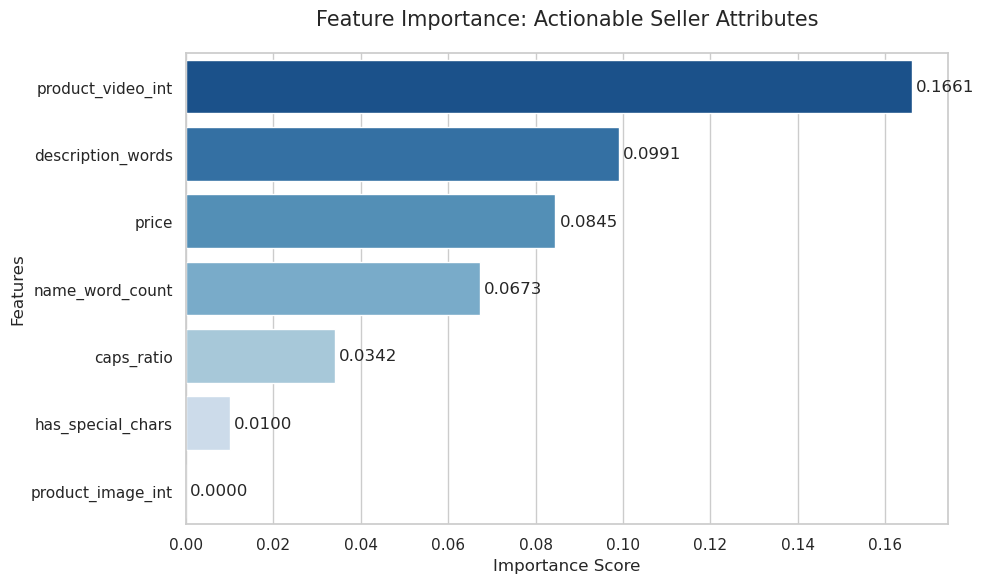

/tmp/ipykernel_18118/163431038.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


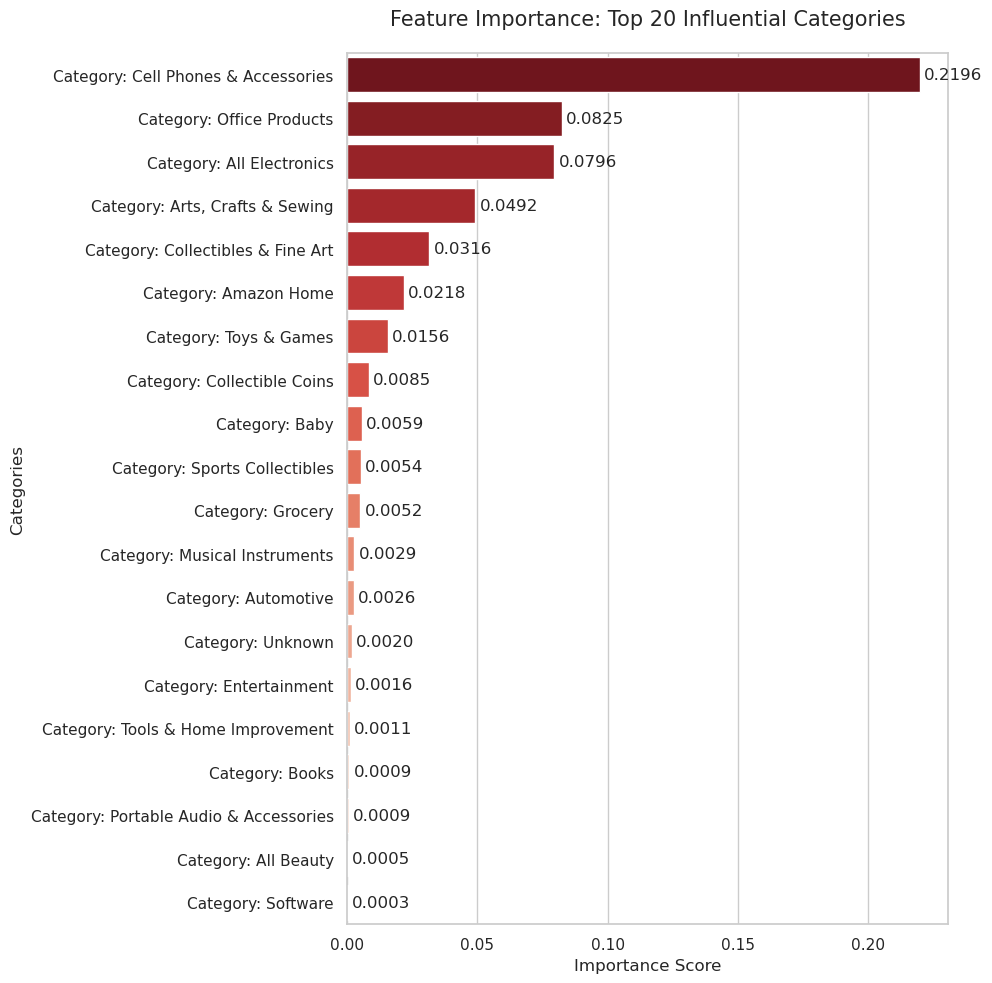

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Separate DataFrames
df_numeric = df_importance[df_importance['Type'] == 'Numeric'].copy()
df_category = df_importance[df_importance['Type'] == 'Category'].copy()

# Sort by Importance
df_numeric = df_numeric.sort_values("Importance", ascending=False)
df_category = df_category.sort_values("Importance", ascending=False).head(20)

# Set plot style
sns.set_theme(style="whitegrid")

# Chart 1: Numeric Features (Actionable)
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(
    x="Importance", 
    y="Feature", 
    data=df_numeric, 
    palette="Blues_r"
)

plt.title("Feature Importance: Actionable Seller Attributes", fontsize=15, pad=20)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

# Chart 2: Category Features (Top 20 Impact)
plt.figure(figsize=(10, 10))
ax2 = sns.barplot(
    x="Importance", 
    y="Feature", 
    data=df_category, 
    palette="Reds_r"
)

plt.title("Feature Importance: Top 20 Influential Categories", fontsize=15, pad=20)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Categories", fontsize=12)

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.4f', padding=3)

plt.tight_layout()
plt.show()

#### Summary
Unfortunately, with the current dataset, it was difficult to build a more accurate prediction model. However, the insights obtained from the machine learning process—such as the feature importance results—were still highly valuable and actionable.

#### Feature Importance Analysis

**1. Product Video**\
Product videos have the strongest influence on ratings, while images contribute very little.  
**Recommendation:** Invest in at least one high-quality product video.

**2. Detailed Descriptions**\
Longer and more thorough descriptions are associated with higher ratings.  
**Recommendation:** Write clear and detailed product descriptions.

**3. Price**\
Price has only moderate impact on ratings, likely due to differing expectations across categories.

**4. Title Tricks Don’t Work**\
Title length, ALL CAPS, and special characters show minimal effect on ratings.  
**Recommendation:** Keep titles clean and keyword-focused.


#### Main Product Category Importance
 **1. “Cell Phones & Accessories” is by far the most influential category in predicting product ratings.**
It appears as the longest bar in the chart.
This means that products in this category show **large variability in ratings** and **high diversity in customer complaints**, making the category extremely important for the model when predicting ratings.\
In other words: **“The cell phone accessories market has highly inconsistent and unpredictable ratings.”**

**2. Office Products, Electronics, Arts & Crafts, and similar categories follow in importance.**
These categories also show distinctive rating patterns, so the model uses them as helpful signals when estimating a product's rating.

**3. Categories toward the bottom contribute very little to rating prediction.**
Examples: All Beauty, Software, Books.

This indicates that these categories have **more stable ratings** and **smaller differences between products**, meaning the model does not rely heavily on category information for them.

### Model 2 - Negative Review NLP Analysis
- Using **text(review texts), rating**
- From negatively rated reviews (1-2 stars ratings), we expect to find reason why those customer criticize products using NLP analysis.
- We categorized words into groups. Then, we analyzed and categorized those groups with ChatGPT (Can be done by human hands).

In [26]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.ml import Pipeline
import pandas as pd

# 0. Data Preparation
# Select necessary columns
df_for_ml = df.select("rating", "text")

# Filter for negative reviews (Extracting Negative Review - 1 & 2 star ratings)
df_neg = df_for_ml.filter(
    F.col("rating").isin([1, 2]) & 
    F.col("text").isNotNull()
)

# 1. Text Cleaning

# 1) Convert to lowercase
df_neg_clean = df_neg.withColumn("text_clean", lower(col("text")))

# 2) Remove HTML tags and URLs
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "<[^>]+>", " ")) 
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "http\\S+", "")) 

# 3) Expand English contractions - Some frequently used unimportant words
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "won't", "will not"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "can't", "can not"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "n't", " not"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "'ll", " will"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "'re", " are"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "'ve", " have"))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "'m", " am"))

# 4) Remove numbers and punctuations
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "[^a-z\\s]", ""))

# 5) Remove noise - short words (1-2 characters) & extra whitespace
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "\\b[a-z]{1,2}\\b", ""))
df_neg_clean = df_neg_clean.withColumn("text_clean", regexp_replace("text_clean", "\\s+", " "))
df_neg_clean = df_neg_clean.withColumn("text_clean", F.trim(col("text_clean")))

# 2. Define Stopwords (English + Custom + Spanish)

# A. General words that hinder analysis
custom_stops = [
    "product", "item", "one", "get", "use", "used", "using", 
    "buy", "bought", "buying", "purchase", "purchased", "ordered", "order",
    "came", "got", "sent", "work", "worked", "working", "works", "job",
    "good", "great", "even", "like", "really", "much", "well", "look", "looks",
    "amazon", "seller", "customer", "service", "review",
    "try", "tried", "put", "back", "way", "made", "make", "think", "know", "say", "said",
    "thing", "things", "stuff", "lot", "another", "feature", "issue", "problem"
]

# B. Spanish stopwords (to remove noise)
spanish_stops = [
    "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "las", "por", 
    "un", "para", "con", "no", "una", "su", "al", "lo", "como", "mas", "pero", 
    "sus", "le", "ya", "o", "este", "si", "porque", "esta", "entre", "cuando", 
    "muy", "sin", "sobre", "tambien", "me", "hasta", "hay", "donde", "quien", 
    "desde", "todo", "nos", "durante", "todos", "uno", "les", "ni", "contra", 
    "otros", "ese", "eso", "ante", "ellos", "e", "esto", "mia", "otro", "el",
    "es", "son", "fue"
]

# Combine all stopword lists
final_stop_words = StopWordsRemover.loadDefaultStopWords("english") + custom_stops + spanish_stops

# 3. Build ML Pipeline

# 1) Tokenizer
tokenizer = Tokenizer(inputCol="text_clean", outputCol="tokens")

# 2) StopWordsRemover
remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens",
    stopWords=final_stop_words
)

# 3) CountVectorizer
cv = CountVectorizer(
    inputCol="filtered_tokens",
    outputCol="cv_features",
    vocabSize=10000, 
    minDF=10         
)

# 4) LDA Model
num_topics = 30
lda = LDA(
    k=num_topics,          
    maxIter=50,            
    featuresCol="cv_features",
    seed=42
)

pipeline_neg = Pipeline(stages=[tokenizer, remover, cv, lda])

# 4. Train Model and Extract Results
print("Training LDA model with 30 topics (Cleaned Data)...")
model_neg = pipeline_neg.fit(df_neg_clean)

# Get Vocabulary
cv_model = model_neg.stages[2]
vocab = cv_model.vocabulary

# Get LDA Model
lda_model = model_neg.stages[3]
topics = lda_model.describeTopics(10) # Top 10 words per topic

# 5. Convert to Pandas DataFrame and Print
topics_rdd = topics.rdd.map(lambda row: row['termIndices']).collect()
topic_weights_rdd = topics.rdd.map(lambda row: row['termWeights']).collect()

topic_data = []
for i in range(len(topics_rdd)):
    words = [vocab[idx] for idx in topics_rdd[i]]
    words_str = ", ".join(words)
    topic_data.append({"Topic_ID": i, "Keywords": words_str})

df_topics = pd.DataFrame(topic_data)

# Display settings
pd.set_option('display.max_colwidth', None)

print("LDA Topic Modeling Result (Negative Reviews)")
print(df_topics)

Training LDA model with 30 topics (Cleaned Data)...


LDA Topic Modeling Result (Negative Reviews)
    Topic_ID  \
0          0   
1          1   
2          2   
3          3   
4          4   
5          5   
6          6   
7          7   
8          8   
9          9   
10        10   
11        11   
12        12   
13        13   
14        14   
15        15   
16        16   
17        17   
18        18   
19        19   
20        20   
21        21   
22        22   
23        23   
24        24   
25        25   
26        26   
27        27   
28        28   
29        29   

                                                                                         Keywords  
0                         light, months, year, unit, lights, warranty, last, lasted, new, stopped  
1                  case, phone, cover, iphone, fit, dropped, protect, screen, plastic, protection  
2                    charge, battery, charger, charging, phone, power, cord, cable, charged, plug  
3                           cheap, worth, money, price, be

In [28]:
# Mapping Dictionary (Topic_ID -> English Label)
topic_name_map = {
    # Group 1: Tech & Functionality
    2: "Charging/Battery Failure",
    9: "Printer/Ink Incompatibility",
    12: "Audio/Hardware Failure",
    24: "Sim Card/Connectivity",
    26: "Instructions/Missing Parts",
    29: "Cable/Accessory Failure",

    # Group 2: Durability & Quality
    0: "Stopped Working (Short Life)",
    3: "Poor Value (Junk)",
    17: "Broke Within Weeks",
    19: "Poor Material (Flimsy Plastic)",
    20: "Adhesion Failure (Won't Stick)",
    29: "General Dissatisfaction",
    
    # Group 3: Fitment & Assembly
    1: "Phone Case Fitment",
    12: "Assembly/Screw Alignment",
    15: "Car Seat/Holder Fit",
    16: "Screen Protector Bubbles/Crack",
    21: "Vehicle Model Incompatibility",
    27: "Sizing Issues (Too Small)",

    # Group 4: Shipping, Service & Description
    10: "Return Window Issues",
    11: "Refund/Service Issues",
    14: "Arrived Damaged/Opened",
    22: "Description/Color Mismatch",
    
    # Group 5: Food & Taste
    8: "Water/Feeder Leakage",
    23: "Stale/Bad Taste (Food)",
    28: "Beverage Flavor Issues",

    # Group 6: Specific Niche
    4: "Art/Office Supplies Quality",
    5: "Hair/Beauty Product Quality",
    6: "Cutting Tools/Blades",
    7: "Pens Dried Out",
    13: "Plants/Gardening Damage",
    25: "Wearables/Watch Bands"
}

# Apply the mapping
df_topics['Topic_Category'] = df_topics['Topic_ID'].map(topic_name_map)
df_topics['Topic_Category'] = df_topics['Topic_Category'].fillna("Other Issues")

# Display Final Table
print(df_topics[['Topic_Category', 'Keywords', 'Topic_ID']])

                    Topic_Category  \
0     Stopped Working (Short Life)   
1               Phone Case Fitment   
2         Charging/Battery Failure   
3                Poor Value (Junk)   
4      Art/Office Supplies Quality   
5      Hair/Beauty Product Quality   
6             Cutting Tools/Blades   
7                   Pens Dried Out   
8             Water/Feeder Leakage   
9      Printer/Ink Incompatibility   
10            Return Window Issues   
11           Refund/Service Issues   
12        Assembly/Screw Alignment   
13         Plants/Gardening Damage   
14          Arrived Damaged/Opened   
15             Car Seat/Holder Fit   
16  Screen Protector Bubbles/Crack   
17              Broke Within Weeks   
18                    Other Issues   
19  Poor Material (Flimsy Plastic)   
20  Adhesion Failure (Won't Stick)   
21   Vehicle Model Incompatibility   
22      Description/Color Mismatch   
23          Stale/Bad Taste (Food)   
24           Sim Card/Connectivity   
25          

#### Negative Review Topic Grouping (Root Cause Analysis)

**Group A. Tech & Functionality**  
This represents the most specific and critical functional failures.

 **Topic 2 — Charging/Power**
- **Keywords:** charge, battery, cord, plug  
- **Meaning:** Charging failure or poor cable contact.

 **Topic 9 — Printer**
- **Keywords:** printer, ink, cartridge, printing  
- **Meaning:** Ink recognition failure, poor print quality.

 **Topic 16 — Screen Protection**
- **Keywords:** screen, protector, bubbles, edges  
- **Meaning:** Bubbles appearing, edges lifting.

 **Topic 18 — Audio/Buttons**
- **Keywords:** sound, volume, hear, buttons  
- **Meaning:** No sound or button malfunction.

 **Topic 24 — Connectivity/SIM**
- **Keywords:** card, sim, phone, call  
- **Meaning:** SIM card recognition failure, call connection issues.

---

 **Group B. Durability & Quality**  
This group is closely associated with reviews mentioning *“waste of money”* and severe quality issues.

 **Topic 17 — Early Breakage**
- **Keywords:** broke, apart, fell, weeks  
- **Meaning:** Broke apart within weeks of purchase.

 **Topic 19 — Poor Material**
- **Keywords:** plastic, cheap, flimsy, metal  
- **Meaning:** “Thought it was metal, but it's cheap plastic.”

 **Topic 0 — Short Lifespan**
- **Keywords:** stopped, months, warranty, lasted  
- **Meaning:** Stopped working immediately after the warranty expired.

 **Topic 3 & 29 — Emotional Venting**
- **Keywords:** junk, waste, money, garbage  
- **Meaning:** Emotional frustration rather than a specific technical fault.

---

 **Group C. Assembly & Installation**  
Common in items requiring user assembly or installation.

 **Topic 12 — Screws/Assembly**
- **Keywords:** holes, screws, install, bolts  
- **Meaning:** Screw holes do not align; assembly impossible.

 **Topic 20 — Adhesion Problems**
- **Keywords:** stick, adhesive, fall, wall  
- **Meaning:** Item fails to adhere properly; falls off immediately.

 **Topic 26 — Manuals/Parts**
- **Keywords:** instructions, missing, parts, wrong  
- **Meaning:** Missing instructions or missing parts.

---

 **Group D. Shipping & Misleading**  
Issues related to logistics or misleading product information.

 **Topic 14 — Damaged Arrival**
- **Keywords:** box, broken, opened, smell  
- **Meaning:** Package arrived torn, broken, or with odor.

 **Topic 22 — Description Mismatch**
- **Keywords:** picture, color, description, nothing  
- **Meaning:** Product looks completely different from photos or color.

 **Topic 10 & 11 — Returns/Refunds**
- **Keywords:** return, refund, days, company  
- **Meaning:** Difficult return process or delayed refunds.

---

 **Group E. Domain-Specific Complaints**  
Issues unique to particular product categories.

 **Topic 23 & 28 — Food/Taste**
- **Keywords:** taste, flavor, stale, coffee, candy  
- **Meaning:** Stale, tasteless, or old food products.

 **Topic 8 — Water/Pets**
- **Keywords:** water, pool, feeder, suction  
- **Meaning:** Pet feeder or pool pump malfunction.

 **Topic 7 — Stationery**
- **Keywords:** pen, ink, write, dry  
- **Meaning:** Pen ink dried out; doesn’t write.

 **Topic 13 — Plants/Gardening**
- **Keywords:** plants, dead, cracked  
- **Meaning:** Plants arrived dead; pots cracked.

---

 **Group F. Fitment & Sizing**  
Common in accessories, covers, and vehicle-related items.

 **Topic 1 — Phone Case Fitment**
- **Keywords:** case, fit, dropped, protect  
- **Meaning:** Phone case does not fit the device.

 **Topic 15 & 21 — Vehicle Accessories**
- **Keywords:** car, seat, truck, fit  
- **Meaning:** Does not fit the specific vehicle model.

 **Topic 27 — Cover Sizing**
- **Keywords:** small, size, rain, cover  
- **Meaning:** Cover size is too small.


#### Summary

This analysis was conducted using our entire dataset. However, if sellers narrow the scope of the data—by filtering based on their own product group (such as by parent_asin or store)—they can perform the same analysis in a more targeted way. This would enable them to categorize and understand the specific types of customer complaints that are most relevant to their products, making the insights even more useful.

## Conclusion

Our exploratory analysis reveals several actionable insights into customer satisfaction and product performance on Amazon’s platform.

### Key Findings

**1. Product Category Performance Patterns**
Amazon's highest satisfaction levels occur in general, functional product categories such as **Baby Products, Office Products, and Grocery & Gourmet Food**, which consistently maintain weighted average ratings above 4.2. In contrast, more personal and preference-driven segments like **Beauty, Health & Personal Care, and Cell Phones & Accessories** exhibit lower ratings (below 4.0), reflecting the challenge of meeting diverse customer expectations in subjective categories.

* **Business Action**: Prioritize personalization strategies—tailored recommendations, improved product imagery, and targeted review encouragement—especially for categories where subjective preference plays a greater role. For functional categories with high ratings, focus on maintaining quality consistency.

**2. Price-Rating Relationship: Limited Direct Correlation**
Across most price ranges, ratings cluster between 4 and 5 stars, indicating that **price is not a primary driver of satisfaction**. However, very high-priced items (>$1,750) rarely receive extremely low ratings (<2.5), possibly due to higher quality assurance or more selective buyer groups. Our Price Fairness Index (PFI) analysis reveals that most products on Amazon are fairly priced relative to their category and price bucket, though certain categories show long-tail distributions of underperforming products.

* **Business Action**: Sellers should not assume that price increases automatically improve satisfaction. Instead, focus on price-value alignment within category-specific benchmarks. Monitor PFI to identify products that are significantly overpriced or underpriced relative to category norms.

**3. Content Quality and Product Presentation: Visual Content Matters**
Products featuring **videos consistently receive higher ratings** than those without, while images show less clear impact. Interestingly, products with **shorter or medium-length descriptions** perform slightly better than long, text-heavy ones, suggesting that concise, clear information improves readability and trust. This supports the hypothesis that visual and clear content presentation positively affects perceived product quality.

* **Business Action**: 
  - Invest in at least one high-quality product video (highest ROI based on feature importance analysis)
  - Write clear, detailed but concise product descriptions (avoid overly long text)
  - Consider A/B testing content length to optimize engagement

**4. Helpful Votes as Early Warning Signals**
When 1-star reviews accumulate many "helpful" votes, average product ratings drop significantly (as low as 2.72). This pattern indicates that customers collectively signal quality or service issues through engagement behavior. The concentration of helpful votes on critical reviews serves as a red flag for potential product quality problems.

* **Business Action**: Monitor helpful-vote concentration as an early-warning indicator for emerging product problems or reputation risks. Integrate this metric into quality-control dashboards for proactive intervention before ratings significantly decline.

**5. Product Lifecycle Stability: Ratings Remain Consistent Over Time**
Across all lifecycle stages (early, growth, mature, late), average ratings remain relatively stable, suggesting that **product quality expectations stay consistent from launch to maturity**. However, certain categories—such as **Musical Instruments, Arts & Crafts, and Baby Products**—consistently outperform others throughout their lifecycle, indicating stronger product-market fit. Categories like **All Beauty, Health & Personal Care, and Cell Phones** show lower ratings in early stages, which may be related to wide variation in individual user experiences, requiring more reviews to stabilize ratings.

* **Business Action**: 
  - For categories with early-stage rating volatility (Beauty, Personal Care), strengthen promotional efforts to encourage customer reviews during the early phase
  - Learn from categories that maintain high ratings across all lifecycle stages
  - Monitor mid-life "rating crashes" as indicators of quality degradation or supplier changes

**6. Text Length Patterns: Detailed Complaints vs. Brief Enthusiasm**
Analysis of review text length reveals that **1-star reviews tend to be longer** (customers write detailed complaints), while **5-star reviews are typically shorter** (brief expressions of satisfaction). Ratings 2-4 show similar length distributions. This pattern suggests that text length alone is not a primary driver of ratings but can help prioritize which reviews sellers should read manually.

* **Business Action**: Prioritize reading longer negative reviews (1-2 stars) as they contain detailed complaint information that can guide product improvements.

**7. Verified Purchase Analysis: Category-Specific Patterns**
The correlation between verified purchases and ratings is very weak overall, but category-specific patterns emerge. **Musical Instruments, Baby Products, Office Products, Automotive, and Grocery** categories show noticeably higher skewness toward high ratings in verified purchase reviews compared to non-verified purchases. In contrast, **All Beauty** products show relatively lower skewness for verified purchases.

* **Business Action**: Implement targeted strategies to increase verified purchases in categories where they show positive correlation with ratings (Musical Instruments, Baby Products, Office Products, Automotive, Grocery).

**8. Negative Review Root Causes: Six Major Complaint Categories**
Through NLP topic modeling of negative reviews, we could provide sellers insights about reasons why negative reviews give low ratings on their products.

* **Business Action**: Use topic modeling on seller's own product reviews to identify specific complaint patterns and address root causes systematically.

### Limitations

1. **Rating Bias**: Ratings may not fully capture product quality, as they can be influenced by personal preferences, limited review volume, or factors outside the seller's control (delivery issues, packaging).

2. **Brand Effects**: The analysis does not account for brand reputation or customer loyalty, which may strongly affect rating behavior regardless of price or category.

3. **Content Quality Measurement**: Content quality was inferred from metadata (presence of images/videos) rather than directly measured (actual image/video clarity or linguistic quality).

4. **Limited Product Categories**: Due to resource limitations, we included only 10 out of the 34 available categories.

### Next Steps

**Data Enrichment**: Incorporate external data sources (competitor pricing, market trends, seasonal patterns) and sentiment analysis results from review text to refine understanding.

**Modeling Enhancement**: With better data variance, develop more accurate prediction models incorporating review text sentiment, temporal variables, and brand information to predict future satisfaction scores.

**Monitoring System**: Build automated alerts for anomalies in helpful-vote concentration, sudden rating drops, or PFI deviations to support real-time decision-making.

**Category-Specific Strategies**: Develop tailored improvement strategies for each product category based on their unique performance patterns and complaint types.

**A/B Testing Framework**: Implement controlled experiments to validate the causal impact of content improvements (videos, description length) on ratings and conversion rates.

### Challenges Encountered During the Cleaning Process

The data cleaning process for both the meta and review datasets presented several challenges that required multiple iterations of debugging and optimization:

1. **Schema Inconsistencies Across Categories**  
   - Each product category (e.g., All_Beauty, Automotive, Pet_Supplies) had slightly different schemas in the raw Parquet files.  
   - Columns like `price`, `average_rating`, and `categories` sometimes appeared with conflicting data types (BINARY, STRING, DOUBLE), causing merge and union operations to fail.  
   - This required explicitly casting all numeric and array fields to consistent types before union.

2. **Nested and Array Columns**  
   - The `categories` field was stored as nested arrays with inconsistent depths (e.g., `[["Beauty","Hair"]]` vs `["Beauty","Hair"]`).  
   - We normalized this by flattening or transforming nested arrays into a consistent single-level string-array structure.

3. **Memory and Performance Constraints**  
   - Running large-scale merges across 13 categories led to Java heap space and OutOfMemoryError exceptions on single-node clusters.  
   - We addressed this by switching to multi-node clusters, batching union operations, and adding intermediate checkpoints.

4. **Null and Missing Values**  
   - Several fields, including `store`, `brand`, and `rating_number`, had high null ratios.  
   - Null-ratio summaries were generated to assess completeness and guide which fields should be retained in the final schema.

5. **Type Conversion Failures in Parquet**  
   - During compaction, Spark raised errors such as “Parquet column cannot be converted: Expected DOUBLE, Found BINARY.”  
   - We resolved this by pre-casting problematic columns (e.g., `price`) to the correct type across all partitions before writing.

6. **Inconsistent Naming Conventions**  
   - Folder and dataset naming varied between singular and plural forms (e.g., `review_` vs `reviews_`), which initially caused read failures.  
   - We built a fallback search mechanism to automatically detect the correct existing path.

7. **Handling Stopped Spark Contexts and Task Failures**  
   - Long-running jobs sometimes caused SparkContext to stop or reject tasks due to thread pool exhaustion.  
   - Resume-safe batching and defensive checks were added so failed categories could be rerun without restarting the entire pipeline.

8. **Maintaining Pre- and Post-Clean Comparability**  
   - To ensure no data loss or transformation errors, both the bronze (raw) and silver (cleaned) datasets were validated using identical sanity checks: row counts, schema validation, null ratio analysis, and per-category counts.

Overall, the cleaning process required careful schema alignment, type enforcement, and resource management to produce a unified dataset suitable for downstream analytics.


### GEN AI Disclosure 

**Using Generative AI tools facilitated the analysis and reporting in different phases of this project. In summary, here are various aspects involved:**

**1) Code Cleaning:** We used ChatGPT to assist us with cleaning and debug code errors as and when needed. 

**2) Research Assistance:** ChatGPT provided dataset summaries for quicker understanding of data

**3) Code Review and Debugging:** ChatGPT helped us in optimizing code performance and debugging issues that would otherwise have prevented steady progress on the project. These tools were also integral in producing the customized code that applied specific color schemes to visualizations.

**4)** All outputs of AI were assessed by our team and were checked for accuracy, originality, and compliance with academic integrity standards.

**5) NLP ML result analysis:** Our NLP process extracted groups of words from the negative reviews, which required manual categorization. However, GenAI helped us by grouping these complaint-related words into several meaningful topics.

### References

1) Case Study: Should a Direct-to-Consumer Company Start Selling on Amazon? https://hbr.org/2019/03/case-study-should-a-direct-to-consumer-company-start-selling-on-amazon
2) User Reviews dataset https://amazon-reviews-2023.github.io/main.html
3) Item Metadata dataset https://amazon-reviews-2023.github.io/main.html